This doc contains initial data cleaning, EDA, and supervised models. I used SMOTE to balance the unbalanced data and built RF, LDA, and logit models using both balanced and unbalanced data for comparison.


# Set up

In [ ]:
install.packages("caret", dependencies = TRUE)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [2]:
install.packages("factoextra", dependencies = TRUE)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘Deriv’, ‘microbenchmark’, ‘doBy’, ‘SparseM’, ‘MatrixModels’, ‘carData’, ‘pbkrtest’, ‘quantreg’, ‘crosstalk’, ‘estimability’, ‘corrplot’, ‘viridis’, ‘car’, ‘DT’, ‘emmeans’, ‘flashClust’, ‘leaps’, ‘multcompView’, ‘scatterplot3d’, ‘ggsci’, ‘cowplot’, ‘ggsignif’, ‘gridExtra’, ‘polynom’, ‘rstatix’, ‘pixmap’, ‘sp’, ‘RcppArmadillo’, ‘abind’, ‘dendextend’, ‘FactoMineR’, ‘ggpubr’, ‘ggrepel’, ‘ade4’, ‘ca’, ‘igraph’, ‘mclust’




In [3]:
library(tidyverse)
library(cluster)
library(caret)
library(randomForest)
library(nnet)
library(MASS)
library(factoextra)
library(gridExtra)
library(corrplot)
library(themis)
library(recipes)
library(mclust)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift


randomForest 4.7-1.2

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:dplyr’:

    combine


The following object is masked from ‘package:ggplot2’:

    margin



Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select




In [4]:
url <- "https://www.dropbox.com/scl/fi/urlp9hfscdn4zvbnkuhf9/Telco-Customer-Churn.csv?rlkey=3tf01re55yrikodjv6225r83i&st=v62mmrt8&dl=1"

temp <- tempfile(fileext = ".csv")
download.file(url, destfile = temp, mode = "wb")

In [5]:
df <- read.csv(temp, stringsAsFactors = FALSE)

# Supervised Learning

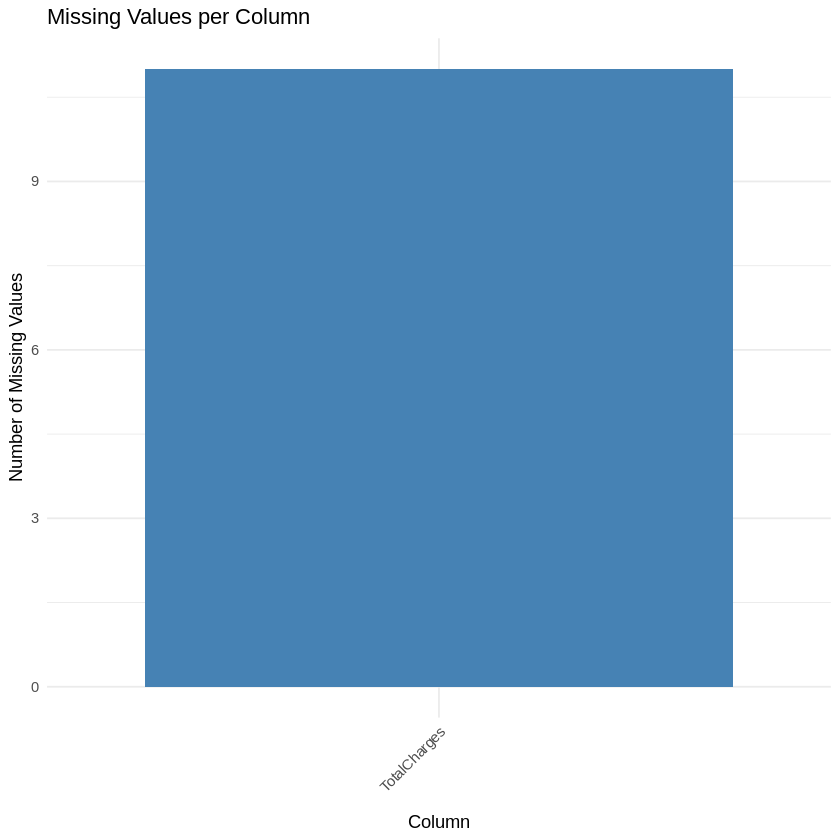

In [6]:
# Count NAs in each column
na_counts <- df %>%
  summarise(across(everything(), ~ sum(is.na(.)))) %>%
  pivot_longer(cols = everything(), names_to = "Column", values_to = "NA_Count") %>%
  filter(NA_Count > 0)  # Only show columns with NAs

# Plot NA
ggplot(na_counts, aes(x = reorder(Column, -NA_Count), y = NA_Count)) +
  geom_bar(stat = "identity", fill = "steelblue") +
  labs(title = "Missing Values per Column",
       x = "Column",
       y = "Number of Missing Values") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

In [7]:
# Convert TotalCharges to numeric and handle missing
df$TotalCharges <- as.numeric(gsub(" ", NA, df$TotalCharges))
df <- na.omit(df)

# Convert variables to factors
df$SeniorCitizen <- as.factor(df$SeniorCitizen)
df$Churn <- as.factor(df$Churn)
categoricals <- c("gender", "Partner", "Dependents", "PhoneService",
                  "MultipleLines", "InternetService", "OnlineSecurity",
                  "OnlineBackup", "DeviceProtection", "TechSupport",
                  "StreamingTV", "StreamingMovies", "Contract",
                  "PaperlessBilling", "PaymentMethod")
df[categoricals] <- lapply(df[categoricals], as.factor)

# Drop customerID
df <- df %>% dplyr::select(-customerID)

In [8]:
# Create recipe to convert all categorical vars to dummy vars
churn_recipe <- recipe(Churn ~ ., data = df) %>%
  step_dummy(all_nominal_predictors())

# Prep and bake to apply dummies to full data
prep_recipe <- prep(churn_recipe)
df_dummy <- bake(prep_recipe, new_data = NULL)


In [9]:
# Split data AFTER dummy conversion
set.seed(123)
trainIndex <- createDataPartition(df_dummy$Churn, p = 0.7, list = FALSE)
train <- df_dummy[trainIndex, ]
test <- df_dummy[-trainIndex, ]

In [10]:
# Apply SMOTE to training set
train$Churn <- as.factor(train$Churn)

smote_recipe <- recipe(Churn ~ ., data = train) %>%
  step_smote(Churn)

prep_smote <- prep(smote_recipe)
train_smote <- bake(prep_smote, new_data = NULL)

# Check class balance
table(train_smote$Churn)




  No  Yes 
3615 3615 

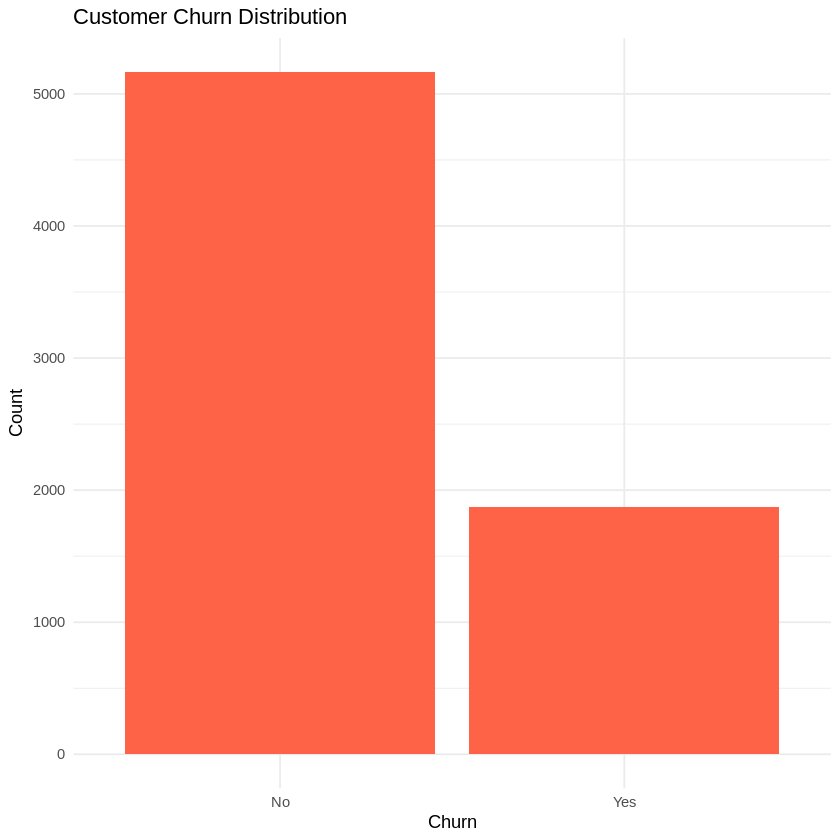

In [11]:
# Churn Distribution
ggplot(df, aes(x = Churn)) +
  geom_bar(fill = "tomato") +
  labs(title = "Customer Churn Distribution", x = "Churn", y = "Count") +
  theme_minimal()


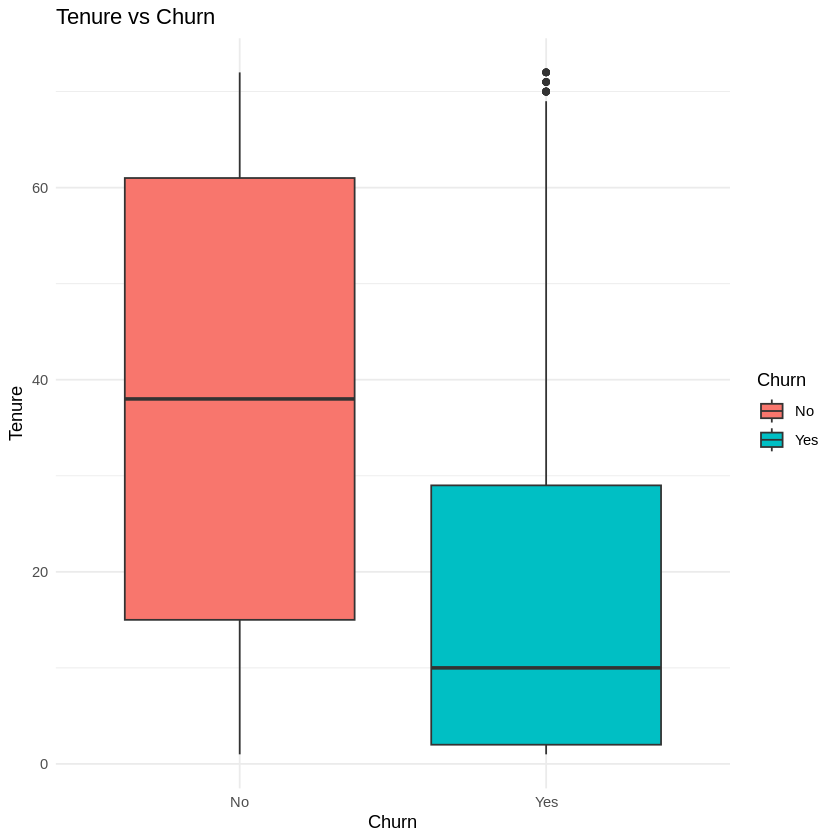

In [12]:
# Tenure vs Churn
ggplot(df, aes(x = Churn, y = tenure, fill = Churn)) +
  geom_boxplot() +
  labs(title = "Tenure vs Churn", x = "Churn", y = "Tenure") +
  theme_minimal()

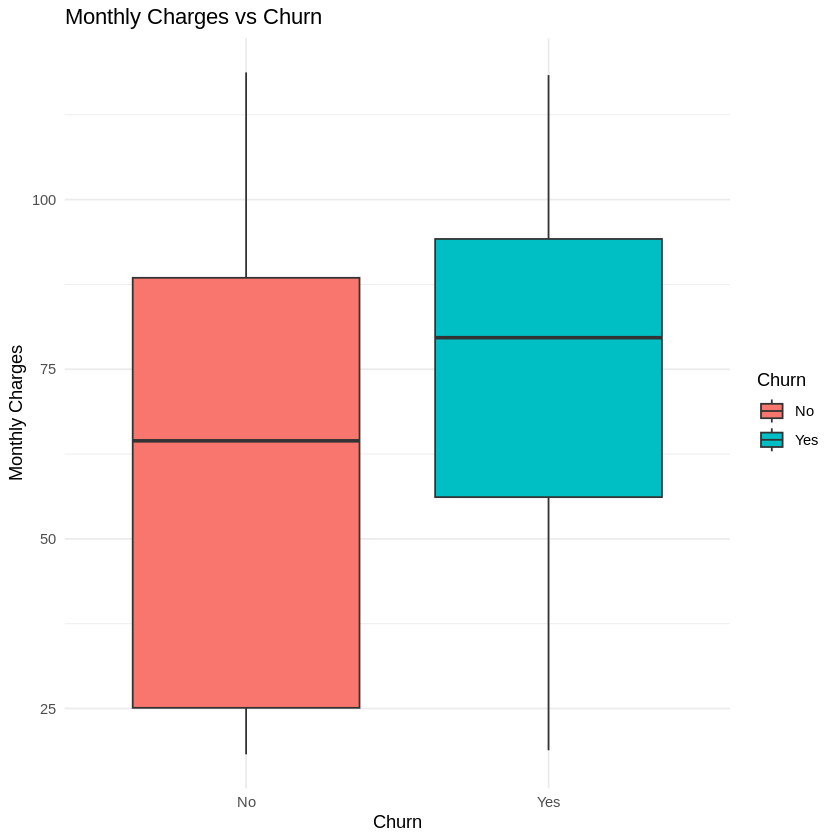

In [13]:
# Monthly Charges by Churn
ggplot(df, aes(x = Churn, y = MonthlyCharges, fill = Churn)) +
  geom_boxplot() +
  labs(title = "Monthly Charges vs Churn", x = "Churn", y = "Monthly Charges") +
  theme_minimal()

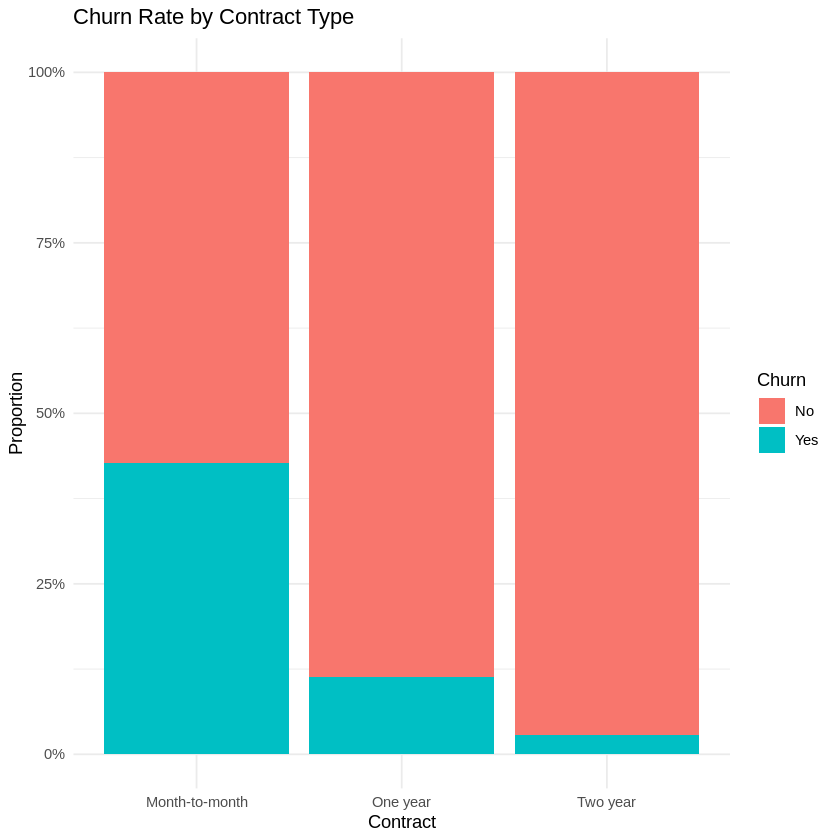

In [14]:
# Contract Type and Churn
ggplot(df, aes(x = Contract, fill = Churn)) +
  geom_bar(position = "fill") +
  labs(title = "Churn Rate by Contract Type", y = "Proportion", x = "Contract") +
  scale_y_continuous(labels = scales::percent) +
  theme_minimal()

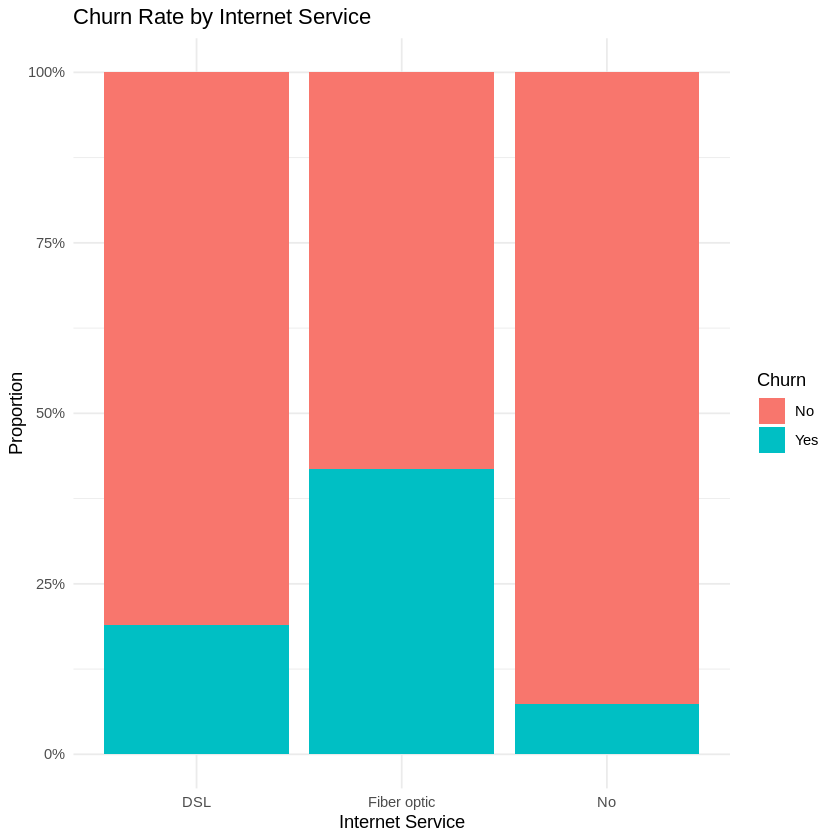

In [15]:
# Internet Service vs Churn
ggplot(df, aes(x = InternetService, fill = Churn)) +
  geom_bar(position = "fill") +
  labs(title = "Churn Rate by Internet Service", y = "Proportion", x = "Internet Service") +
  scale_y_continuous(labels = scales::percent) +
  theme_minimal()


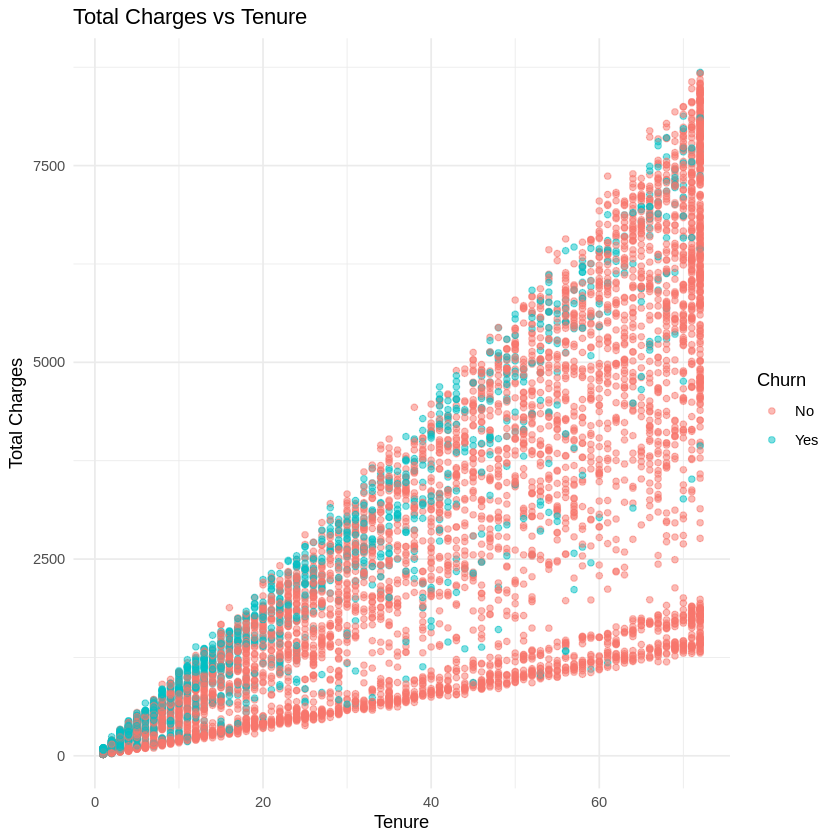

In [16]:
# Total Charges vs Tenure
ggplot(df, aes(x = tenure, y = TotalCharges, color = Churn)) +
  geom_point(alpha = 0.5) +
  labs(title = "Total Charges vs Tenure", x = "Tenure", y = "Total Charges") +
  theme_minimal()

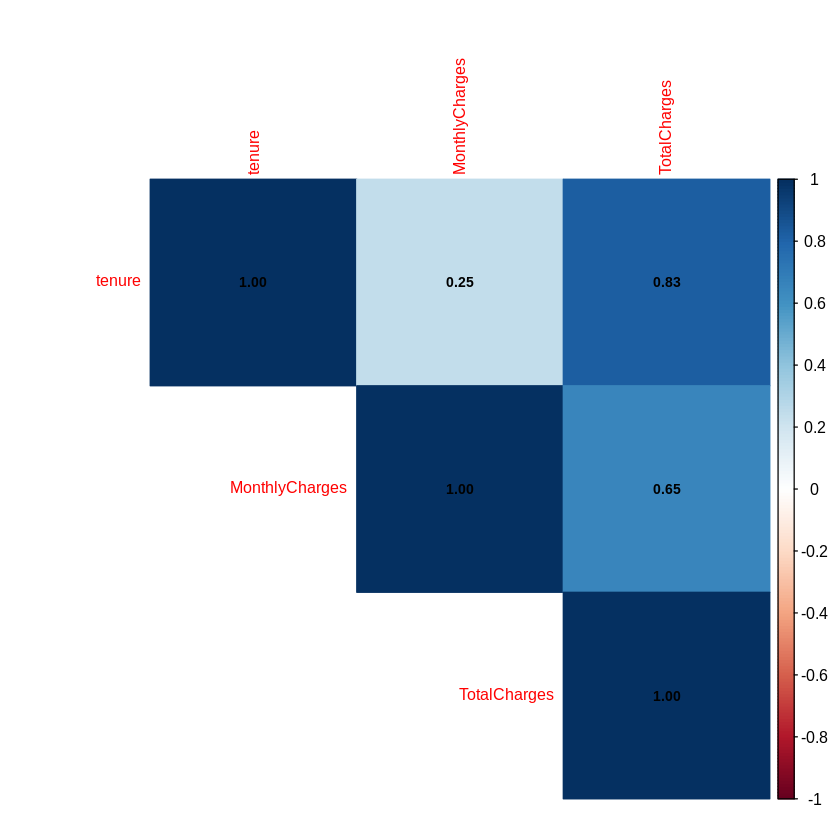

In [17]:
# Correlation Matrix (numeric only)
num_df <- df %>% select_if(is.numeric)
cor_matrix <- cor(num_df, use = "complete.obs")
corrplot(cor_matrix, method = "color", type = "upper",
         tl.cex = 0.8, number.cex = 0.7, addCoef.col = "black")

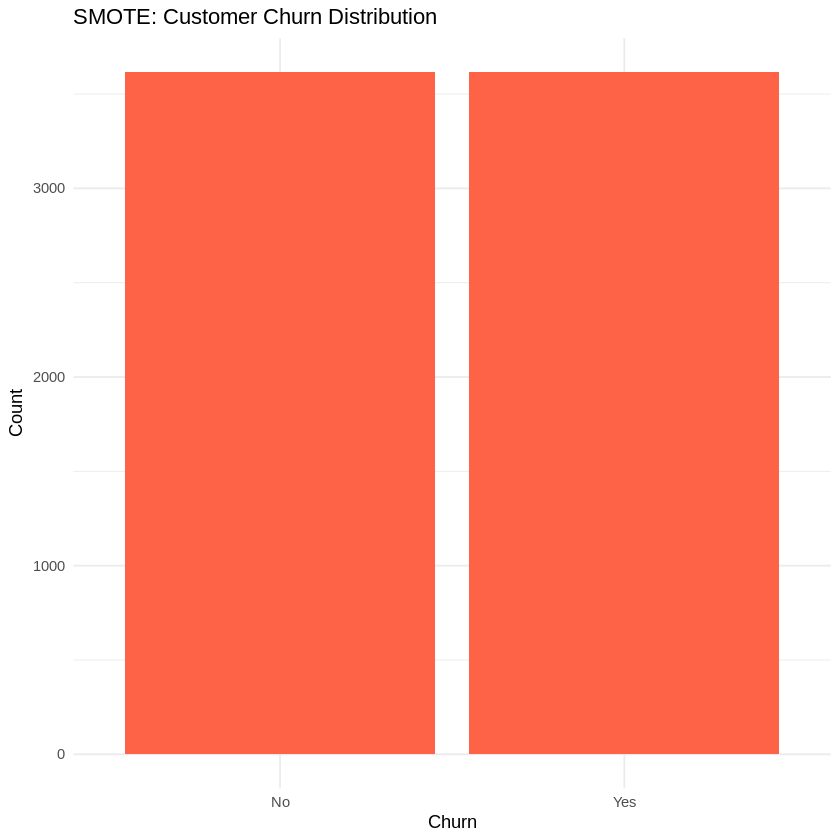

In [18]:
# Churn distribution using SMOTE data
ggplot(train_smote, aes(x = Churn)) +
  geom_bar(fill = "tomato") +
  labs(title = "SMOTE: Customer Churn Distribution", x = "Churn", y = "Count") +
  theme_minimal()


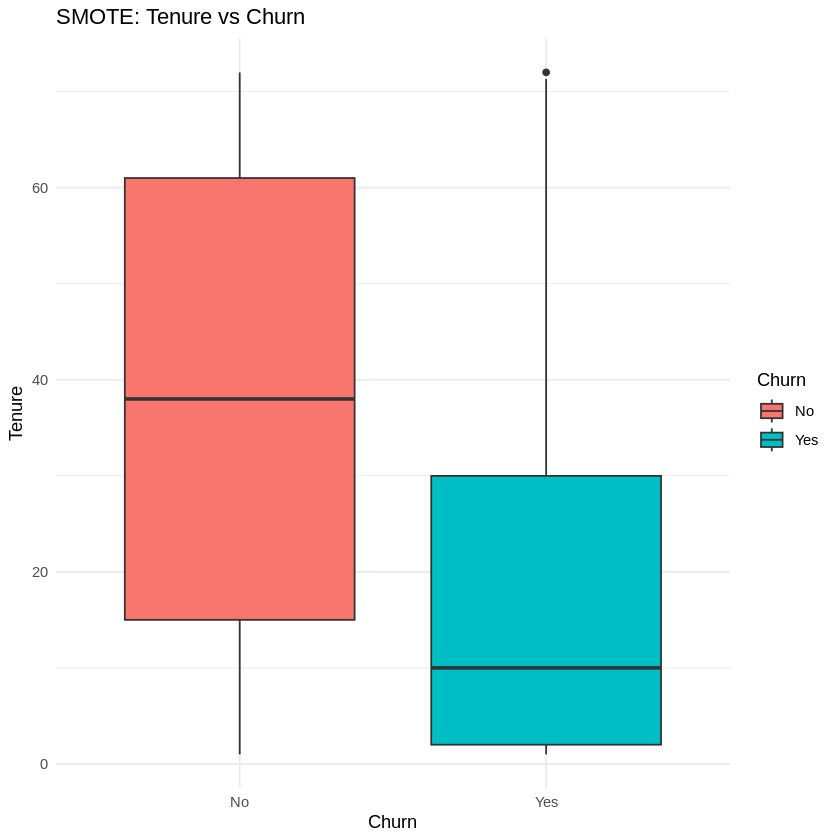

In [19]:
# Tenure vs Churn using SMOTE data
ggplot(train_smote, aes(x = Churn, y = tenure, fill = Churn)) +
  geom_boxplot() +
  labs(title = "SMOTE: Tenure vs Churn", x = "Churn", y = "Tenure") +
  theme_minimal()

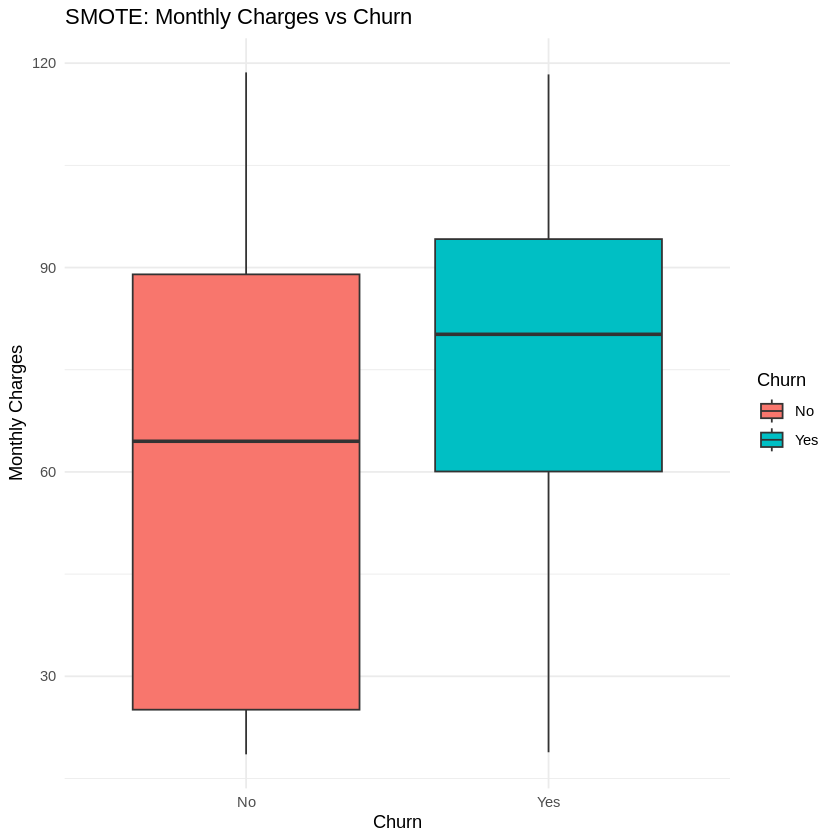

In [20]:
# Monthly Charges vs Churn using SMOTE data
ggplot(train_smote, aes(x = Churn, y = MonthlyCharges, fill = Churn)) +
  geom_boxplot() +
  labs(title = "SMOTE: Monthly Charges vs Churn", x = "Churn", y = "Monthly Charges") +
  theme_minimal()

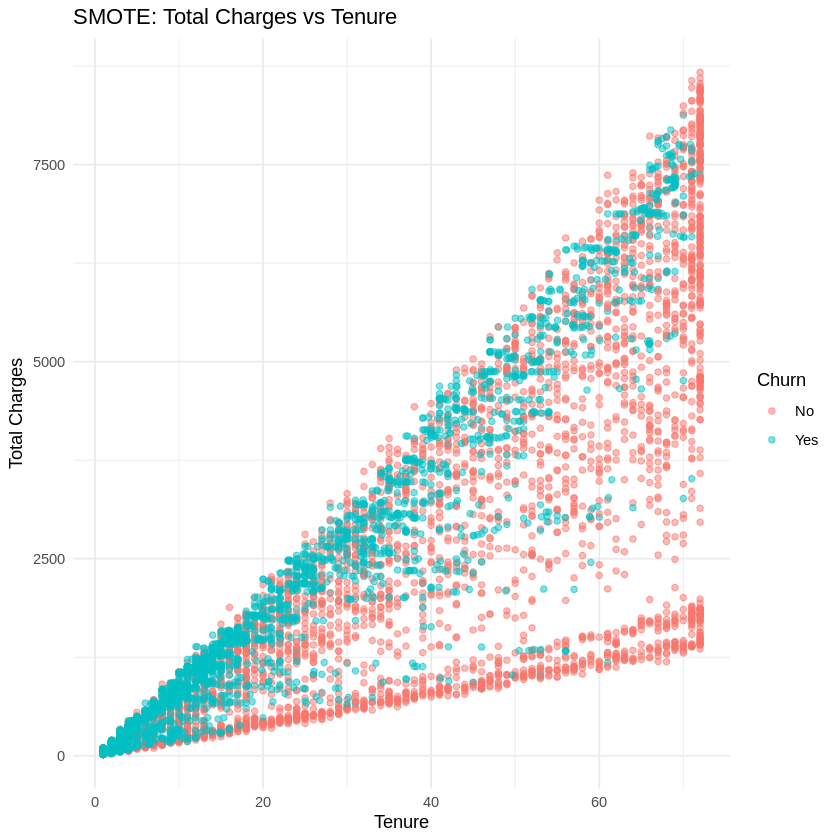

In [21]:
# Total Charges vs Tenure using SMOTE data
ggplot(train_smote, aes(x = tenure, y = TotalCharges, color = Churn)) +
  geom_point(alpha = 0.5) +
  labs(title = "SMOTE: Total Charges vs Tenure", x = "Tenure", y = "Total Charges") +
  theme_minimal()

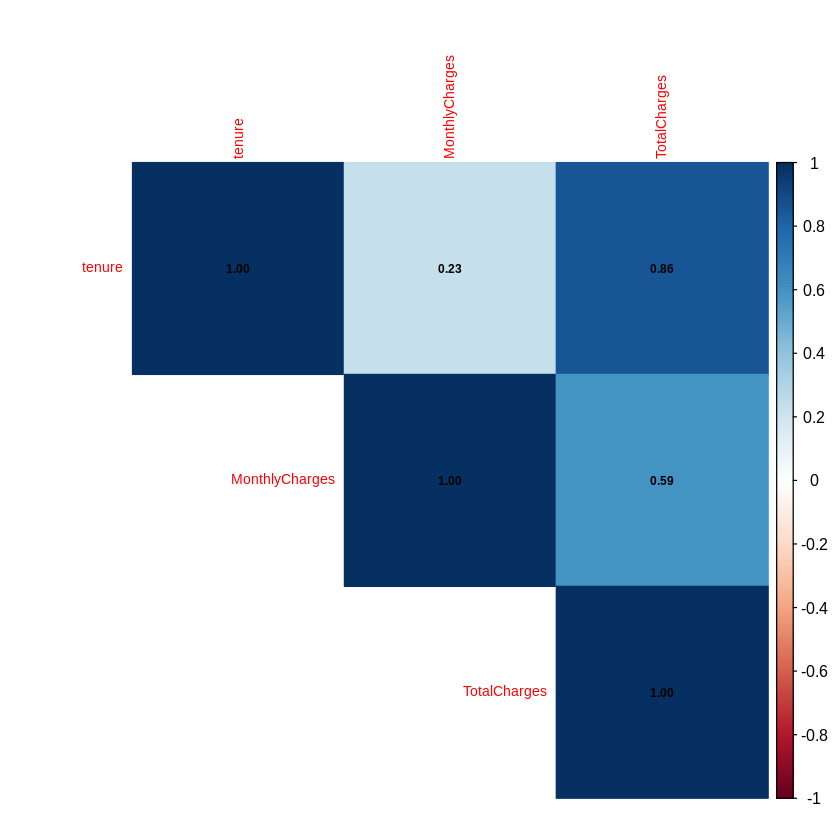

In [22]:
# Correlation matrix of numeric variables using SMOTE data
num_smote <- train_smote %>% dplyr::select(tenure, MonthlyCharges, TotalCharges)
cor_smote <- cor(num_smote, use = "complete.obs")

corrplot(cor_smote, method = "color", type = "upper",
         tl.cex = 0.7, number.cex = 0.6, addCoef.col = "black")


In [23]:
# Random Forest using original training data
rf_orig <- randomForest(Churn ~ ., data = train, ntree = 100)
rf_orig_preds <- predict(rf_orig, test)
rf_orig_cm <- confusionMatrix(rf_orig_preds, test$Churn)

# Random Forest using SMOTE training data
rf_smote <- randomForest(Churn ~ ., data = train_smote, ntree = 100)
rf_smote_preds <- predict(rf_smote, test)
rf_smote_cm <- confusionMatrix(rf_smote_preds, test$Churn)

# Multinomial Logistic Regression using original training data
mlogit_orig <- multinom(Churn ~ ., data = train)
mlogit_orig_preds <- predict(mlogit_orig, test)
mlogit_orig_cm <- confusionMatrix(mlogit_orig_preds, test$Churn)

# Multinomial Logistic Regression using SMOTE training data
mlogit_smote <- multinom(Churn ~ ., data = train_smote)
mlogit_smote_preds <- predict(mlogit_smote, test)
mlogit_smote_cm <- confusionMatrix(mlogit_smote_preds, test$Churn)

# LDA using original training data
lda_orig <- lda(Churn ~ ., data = train)
lda_orig_preds <- predict(lda_orig, test)$class
lda_orig_cm <- confusionMatrix(lda_orig_preds, test$Churn)

# LDA using SMOTE training data
lda_smote <- lda(Churn ~ ., data = train_smote)
lda_smote_preds <- predict(lda_smote, test)$class
lda_smote_cm <- confusionMatrix(lda_smote_preds, test$Churn)

# Print results
rf_orig_cm
rf_smote_cm
mlogit_orig_cm
mlogit_smote_cm
lda_orig_cm
lda_smote_cm

# weights:  32 (31 variable)
initial  value 3413.056717 
iter  10 value 2287.266896
iter  20 value 2067.695228
iter  30 value 2058.616317
final  value 2058.549913 
converged
# weights:  32 (31 variable)
initial  value 5011.454115 
iter  10 value 3660.754777
iter  20 value 3438.497122
iter  30 value 3429.037503
final  value 3429.029709 
converged


Warning message in lda.default(x, grouping, ...):
“variables are collinear”
Warning message in lda.default(x, grouping, ...):
“variables are collinear”


Confusion Matrix and Statistics

          Reference
Prediction   No  Yes
       No  1390  256
       Yes  158  304
                                         
               Accuracy : 0.8036         
                 95% CI : (0.786, 0.8204)
    No Information Rate : 0.7343         
    P-Value [Acc > NIR] : 6.717e-14      
                                         
                  Kappa : 0.4669         
                                         
 Mcnemar's Test P-Value : 1.867e-06      
                                         
            Sensitivity : 0.8979         
            Specificity : 0.5429         
         Pos Pred Value : 0.8445         
         Neg Pred Value : 0.6580         
             Prevalence : 0.7343         
         Detection Rate : 0.6594         
   Detection Prevalence : 0.7808         
      Balanced Accuracy : 0.7204         
                                         
       'Positive' Class : No             
                                         

Confusion Matrix and Statistics

          Reference
Prediction   No  Yes
       No  1358  242
       Yes  190  318
                                          
               Accuracy : 0.7951          
                 95% CI : (0.7772, 0.8121)
    No Information Rate : 0.7343          
    P-Value [Acc > NIR] : 5.339e-11       
                                          
                  Kappa : 0.4587          
                                          
 Mcnemar's Test P-Value : 0.01414         
                                          
            Sensitivity : 0.8773          
            Specificity : 0.5679          
         Pos Pred Value : 0.8488          
         Neg Pred Value : 0.6260          
             Prevalence : 0.7343          
         Detection Rate : 0.6442          
   Detection Prevalence : 0.7590          
      Balanced Accuracy : 0.7226          
                                          
       'Positive' Class : No              
                        

Confusion Matrix and Statistics

          Reference
Prediction   No  Yes
       No  1385  229
       Yes  163  331
                                          
               Accuracy : 0.814           
                 95% CI : (0.7968, 0.8304)
    No Information Rate : 0.7343          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.5048          
                                          
 Mcnemar's Test P-Value : 0.001027        
                                          
            Sensitivity : 0.8947          
            Specificity : 0.5911          
         Pos Pred Value : 0.8581          
         Neg Pred Value : 0.6700          
             Prevalence : 0.7343          
         Detection Rate : 0.6570          
   Detection Prevalence : 0.7657          
      Balanced Accuracy : 0.7429          
                                          
       'Positive' Class : No              
                        

Confusion Matrix and Statistics

          Reference
Prediction   No  Yes
       No  1130  111
       Yes  418  449
                                        
               Accuracy : 0.7491        
                 95% CI : (0.73, 0.7674)
    No Information Rate : 0.7343        
    P-Value [Acc > NIR] : 0.06564       
                                        
                  Kappa : 0.4526        
                                        
 Mcnemar's Test P-Value : < 2e-16       
                                        
            Sensitivity : 0.7300        
            Specificity : 0.8018        
         Pos Pred Value : 0.9106        
         Neg Pred Value : 0.5179        
             Prevalence : 0.7343        
         Detection Rate : 0.5361        
   Detection Prevalence : 0.5887        
      Balanced Accuracy : 0.7659        
                                        
       'Positive' Class : No            
                                        

Confusion Matrix and Statistics

          Reference
Prediction   No  Yes
       No  1369  241
       Yes  179  319
                                          
               Accuracy : 0.8008          
                 95% CI : (0.7831, 0.8176)
    No Information Rate : 0.7343          
    P-Value [Acc > NIR] : 6.91e-13        
                                          
                  Kappa : 0.4706          
                                          
 Mcnemar's Test P-Value : 0.002916        
                                          
            Sensitivity : 0.8844          
            Specificity : 0.5696          
         Pos Pred Value : 0.8503          
         Neg Pred Value : 0.6406          
             Prevalence : 0.7343          
         Detection Rate : 0.6494          
   Detection Prevalence : 0.7638          
      Balanced Accuracy : 0.7270          
                                          
       'Positive' Class : No              
                        

Confusion Matrix and Statistics

          Reference
Prediction   No  Yes
       No  1119  104
       Yes  429  456
                                         
               Accuracy : 0.7472         
                 95% CI : (0.728, 0.7656)
    No Information Rate : 0.7343         
    P-Value [Acc > NIR] : 0.09516        
                                         
                  Kappa : 0.4532         
                                         
 Mcnemar's Test P-Value : < 2e-16        
                                         
            Sensitivity : 0.7229         
            Specificity : 0.8143         
         Pos Pred Value : 0.9150         
         Neg Pred Value : 0.5153         
             Prevalence : 0.7343         
         Detection Rate : 0.5308         
   Detection Prevalence : 0.5802         
      Balanced Accuracy : 0.7686         
                                         
       'Positive' Class : No             
                                         

In [24]:
# Function to extract counts with 'Yes' as the positive class
extract_churn_counts <- function(cm, model_name, data_type) {
  m <- as.table(cm$table)
  data.frame(
    Model = model_name,
    TrainingData = data_type,
    TrueNegative = m["No", "No"],
    FalsePositive = m["Yes", "No"],
    FalseNegative = m["No", "Yes"],
    TruePositive = m["Yes", "Yes"]
  )
}

# Extract confusion matrix counts using churn as the positive class
conf_list <- list(
  extract_churn_counts(rf_orig_cm, "Random Forest", "Original"),
  extract_churn_counts(rf_smote_cm, "Random Forest", "SMOTE"),
  extract_churn_counts(mlogit_orig_cm, "Multinomial Logit", "Original"),
  extract_churn_counts(mlogit_smote_cm, "Multinomial Logit", "SMOTE"),
  extract_churn_counts(lda_orig_cm, "LDA", "Original"),
  extract_churn_counts(lda_smote_cm, "LDA", "SMOTE")
)

# Combine into one summary table
conf_summary <- bind_rows(conf_list)

# View the corrected confusion matrix table
print(conf_summary)


              Model TrainingData TrueNegative FalsePositive FalseNegative
1     Random Forest     Original         1390           158           256
2     Random Forest        SMOTE         1358           190           242
3 Multinomial Logit     Original         1385           163           229
4 Multinomial Logit        SMOTE         1130           418           111
5               LDA     Original         1369           179           241
6               LDA        SMOTE         1119           429           104
  TruePositive
1          304
2          318
3          331
4          449
5          319
6          456


# Unsupervised Learning

## Set up

In [25]:
head(df_dummy)
colnames(df_dummy)

tenure,MonthlyCharges,TotalCharges,Churn,gender_Male,SeniorCitizen_X1,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No.phone.service,⋯,StreamingTV_No.internet.service,StreamingTV_Yes,StreamingMovies_No.internet.service,StreamingMovies_Yes,Contract_One.year,Contract_Two.year,PaperlessBilling_Yes,PaymentMethod_Credit.card..automatic.,PaymentMethod_Electronic.check,PaymentMethod_Mailed.check
<int>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,29.85,29.85,No,0,0,1,0,0,1,⋯,0,0,0,0,0,0,1,0,1,0
34,56.95,1889.50,No,1,0,0,0,1,0,⋯,0,0,0,0,1,0,0,0,0,1
2,53.85,108.15,Yes,1,0,0,0,1,0,⋯,0,0,0,0,0,0,1,0,0,1
45,42.30,1840.75,No,1,0,0,0,0,1,⋯,0,0,0,0,1,0,0,0,0,0
2,70.70,151.65,Yes,0,0,0,0,1,0,⋯,0,0,0,0,0,0,1,0,1,0
8,99.65,820.50,Yes,0,0,0,0,1,0,⋯,0,1,0,1,0,0,1,0,1,0


[1] "tenure"                               
 [2] "MonthlyCharges"                       
 [3] "TotalCharges"                         
 [4] "Churn"                                
 [5] "gender_Male"                          
 [6] "SeniorCitizen_X1"                     
 [7] "Partner_Yes"                          
 [8] "Dependents_Yes"                       
 [9] "PhoneService_Yes"                     
[10] "MultipleLines_No.phone.service"       
[11] "MultipleLines_Yes"                    
[12] "InternetService_Fiber.optic"          
[13] "InternetService_No"                   
[14] "OnlineSecurity_No.internet.service"   
[15] "OnlineSecurity_Yes"                   
[16] "OnlineBackup_No.internet.service"     
[17] "OnlineBackup_Yes"                     
[18] "DeviceProtection_No.internet.service" 
[19] "DeviceProtection_Yes"                 
[20] "TechSupport_No.internet.service"      
[21] "TechSupport_Yes"                      
[22] "StreamingTV_No.internet.service"      
[23] "StreamingTV_Yes"                      
[24] "StreamingMovies_No.internet.service"  
[25] "StreamingMovies_Yes"                  
[26] "Contract_One.year"                    
[27] "Contract_Two.year"                    
[28] "PaperlessBilling_Yes"                 
[29] "PaymentMethod_Credit.card..automatic."
[30] "PaymentMethod_Electronic.check"       
[31] "PaymentMethod_Mailed.check"

In [26]:
# Drop Churn
df_kmeans <- dplyr::select(df_dummy, -Churn)

# Scale the data
df_scaled <- scale(df_kmeans)

,MeanDecreaseGini
tenure,267.298833
MonthlyCharges,224.555559
TotalCharges,270.128310
gender_Male,37.062920
SeniorCitizen_X1,26.476424
Partner_Yes,33.790512
Dependents_Yes,26.851717
PhoneService_Yes,7.584184
MultipleLines_No.phone.service,7.420581
MultipleLines_Yes,29.915577


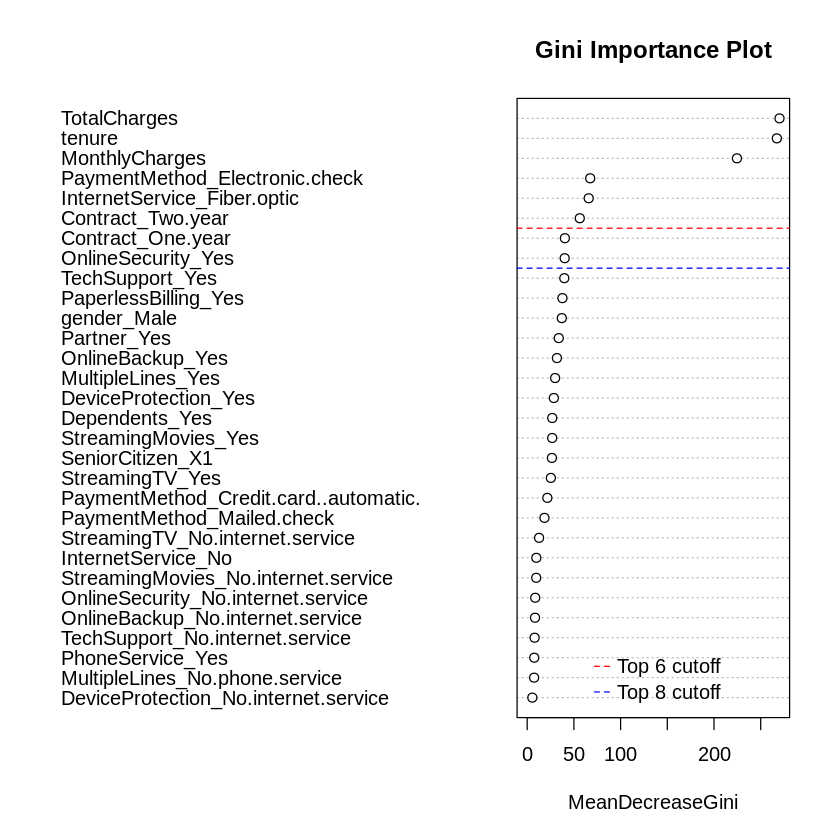

In [27]:
importance(rf_orig)
varImpPlot(rf_orig, main = "Gini Importance Plot")

abline(h = length(rf_orig$importance[,1]) - 6 + 0.5, col = "red", lty = 2)
abline(h = length(rf_orig$importance[,1]) - 8 + 0.5, col = "blue", lty = 2)

legend("bottomright",
       legend = c("Top 6 cutoff", "Top 8 cutoff"),
       col = c("red", "blue"),
       lty = 2,
       bty = "n")

# Top 25% Feature Select

## Set up

In [28]:
select_features <- dplyr::select(
  df_dummy,
  TotalCharges,
  tenure,
  MonthlyCharges,
  InternetService_Fiber.optic,
  PaymentMethod_Electronic.check,
  Contract_Two.year,
  Contract_One.year,
  OnlineSecurity_Yes
)

In [29]:
names(select_features)

[1] "TotalCharges"                   "tenure"                        
[3] "MonthlyCharges"                 "InternetService_Fiber.optic"   
[5] "PaymentMethod_Electronic.check" "Contract_Two.year"             
[7] "Contract_One.year"              "OnlineSecurity_Yes"

In [30]:
feature_scale <- scale(select_features)

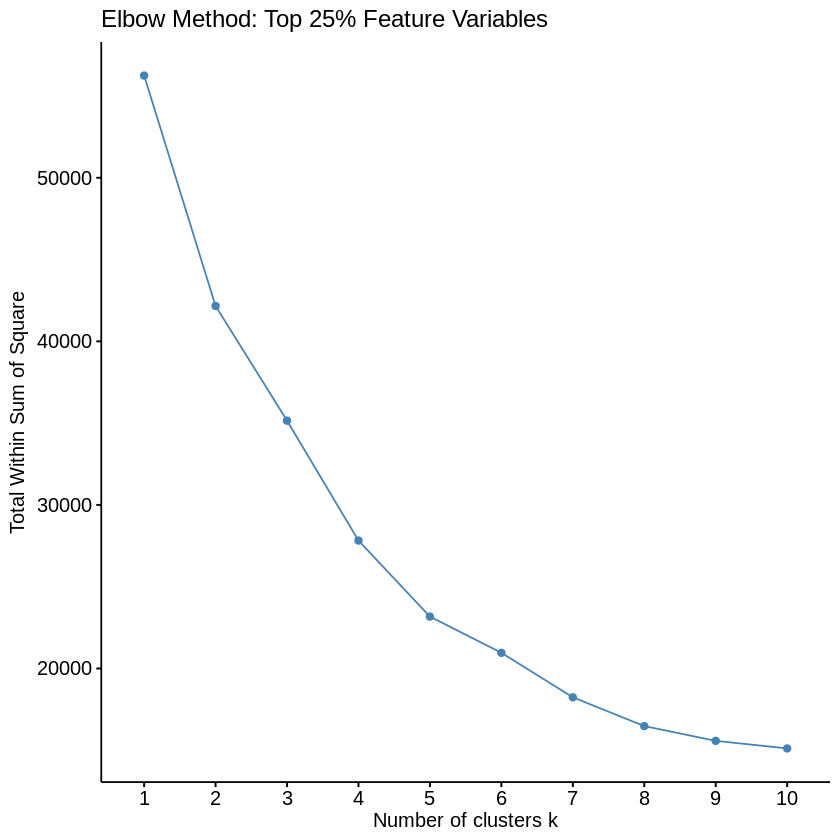

In [32]:
set.seed(123)

fviz_nbclust(feature_scale, kmeans, method = "wss") +
  labs(title = "Elbow Method: Top 25% Feature Variables")

## 4 centers

In [33]:
km_feature <- kmeans(feature_scale, centers = 4, nstart = 25)

In [34]:
df_sel_clustered <- df %>%
  mutate(Cluster = factor(km_feature$cluster))

In [35]:
df_sel_clustered %>%
  count(Cluster, Churn) %>%
  group_by(Cluster) %>%
  mutate(Percent = round(n / sum(n) * 100, 1)) %>%
  ungroup()

Cluster,Churn,n,Percent
<fct>,<fct>,<int>,<dbl>
1,No,911,44.2
1,Yes,1152,55.8
2,No,894,86.3
2,Yes,142,13.7
3,No,1042,94.5
3,Yes,61,5.5
4,No,2316,81.8
4,Yes,514,18.2


In [36]:
low_cid <- 2
high_cid <- 4

In [37]:
df %>%
  mutate(Cluster = df_sel_clustered$Cluster) %>%
  group_by(Cluster) %>%
  summarise(
    tenure = mean(tenure),
    MonthlyCharges = mean(MonthlyCharges),
    Contract_TwoYear = mean(Contract == "Two year"),
    InternetService_Fiber.optic = mean(InternetService == "Fiber optic"),
    PaymentMethod_Electronic.check = mean(PaymentMethod == "Electronic check"),
    TotalCharges = mean(TotalCharges),
    OnlineSecurity = mean(OnlineSecurity == "Yes"),
    Contract_OneYear = mean(Contract == "One year"),
    .groups = "drop"
  )

Cluster,tenure,MonthlyCharges,Contract_TwoYear,InternetService_Fiber.optic,PaymentMethod_Electronic.check,TotalCharges,OnlineSecurity,Contract_OneYear
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,19.62918,86.33233,0.002423655,0.9859428,0.6408143,1768.5771,0.1386331,0.002908386
2,48.54826,81.31424,0.000000000,0.5144788,0.2857143,4038.1922,0.5270270,1.000000000
3,63.78332,87.27498,0.889392566,0.4796011,0.1523119,5592.5197,0.7325476,0.000000000
4,23.62049,34.29383,0.246996466,0.0000000,0.2045936,726.3173,0.1325088,0.151943463


In [38]:
sil <- silhouette(km_feature$cluster, dist(feature_scale))
mean(sil[, 3])

[1] 0.3131785

  cluster size ave.sil.width
1       1 2063          0.42
2       2 1036          0.24
3       3 1103          0.35
4       4 2830          0.25


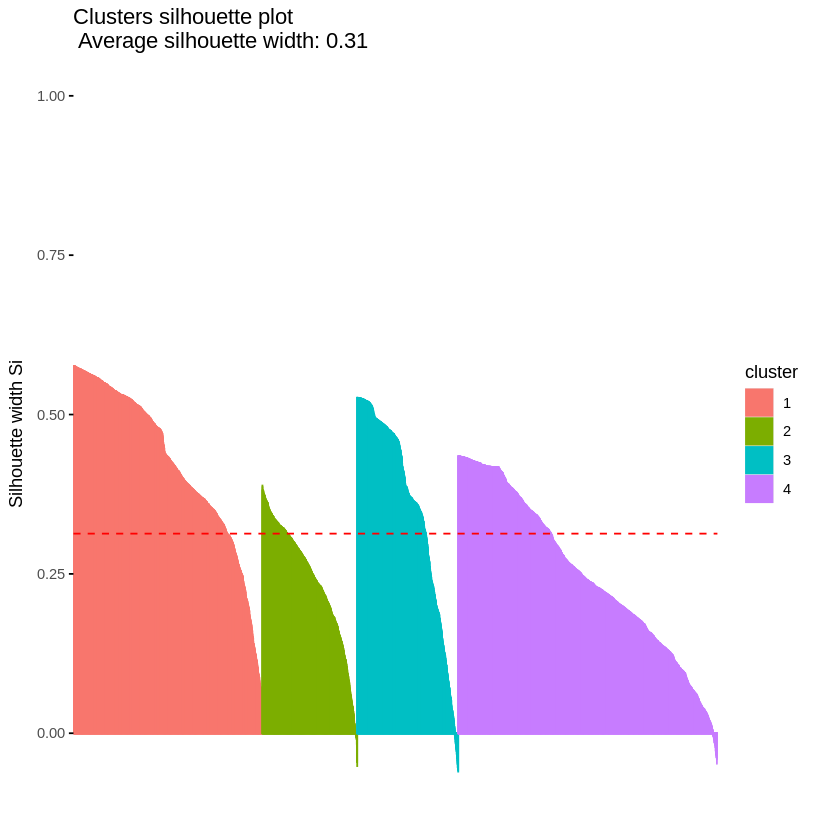

In [39]:
fviz_silhouette(sil)

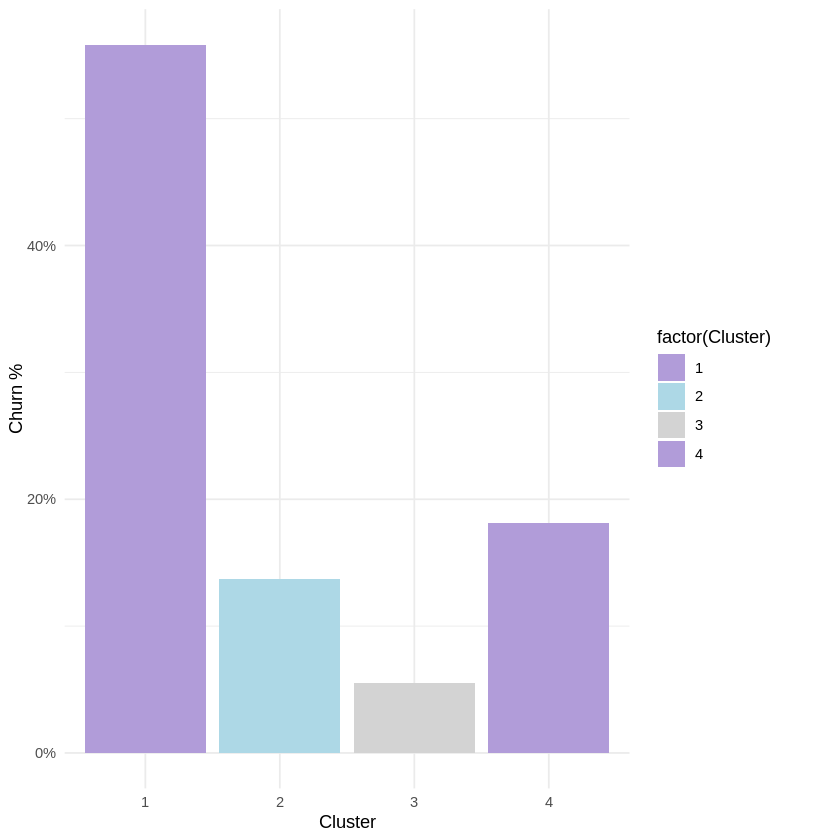

In [40]:
df_sel_clustered %>%
  group_by(Cluster) %>%
  summarise(churn_rate = mean(Churn == "Yes")) %>%
  ggplot(aes(x = factor(Cluster), y = churn_rate, fill = factor(Cluster))) +
  geom_col() +
  scale_y_continuous(labels = scales::percent) +
  labs(x = "Cluster", y = "Churn %") +
  scale_fill_manual(values = c("2" = "#ADD8E6", "3" = "#D3D3D3", "1" = "#B19CD9", "4" = "#B19CD9")) +
  theme_minimal()

In [41]:
get_means <- function(cid) {
  df[df_sel_clustered$Cluster == cid, ] %>%
    summarise(
      Tenure = mean(tenure),
      MonthlyCharges = mean(MonthlyCharges),
      TotalCharges = mean(TotalCharges),
      Contract_TwoYear = mean(Contract == "Two year"),
      Contract_OneYear = mean(Contract == "One year"),
      InternetService_Fiber = mean(InternetService == "Fiber optic"),
      Payment_ECheck = mean(PaymentMethod == "Electronic check"),
      OnlineSecurity = mean(OnlineSecurity == "Yes")
    ) %>%
    t() %>%
    as.data.frame() %>%
    tibble::rownames_to_column("Attribute")
}

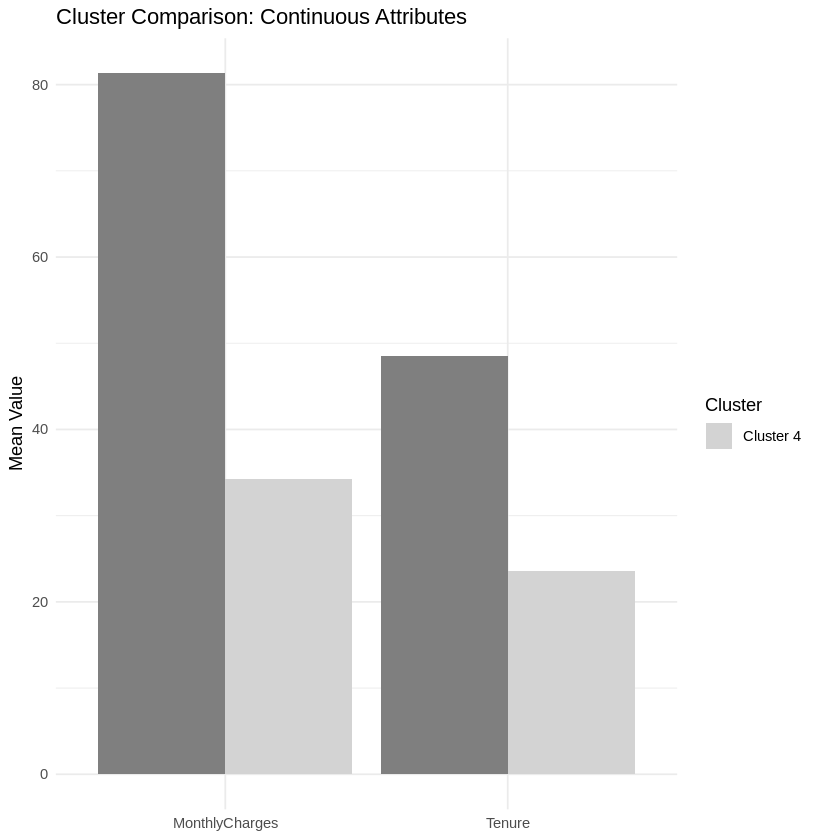

In [42]:
low_vals <- get_means(low_cid)
high_vals <- get_means(high_cid)

plot_df1 <- rbind(
  data.frame(Attribute = low_vals$Attribute, Value = low_vals$V1, Cluster = paste("Cluster", low_cid)),
  data.frame(Attribute = high_vals$Attribute, Value = high_vals$V1, Cluster = paste("Cluster", high_cid))
) %>% filter(Attribute %in% c("Tenure", "MonthlyCharges"))

ggplot(plot_df1, aes(x = Attribute, y = Value, fill = Cluster)) +
  geom_col(position = "dodge") +
  labs(title = "Cluster Comparison: Continuous Attributes", y = "Mean Value", x = NULL) +
  scale_fill_manual(values = c("Cluster 5" = "#ADD8E6", "Cluster 4" = "#D3D3D3")) +
  theme_minimal()

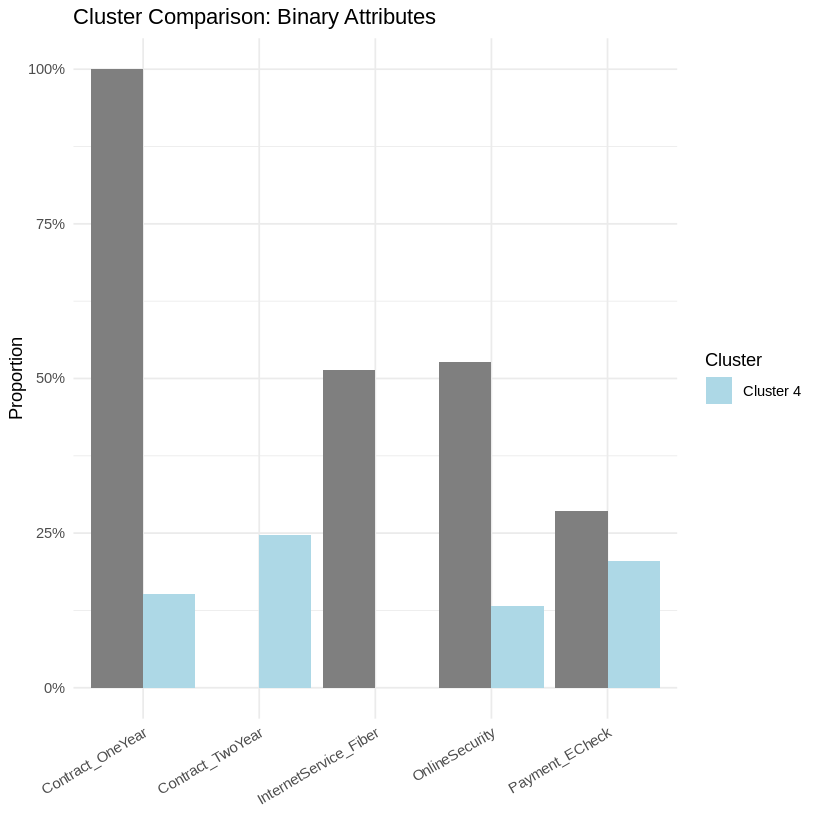

In [43]:
plot_df2 <- rbind(
  data.frame(Attribute = low_vals$Attribute, Value = low_vals$V1, Cluster = paste("Cluster", low_cid)),
  data.frame(Attribute = high_vals$Attribute, Value = high_vals$V1, Cluster = paste("Cluster", high_cid))
) %>% filter(!(Attribute %in% c("Tenure", "MonthlyCharges", "TotalCharges")))

ggplot(plot_df2, aes(x = Attribute, y = Value, fill = Cluster)) +
  geom_col(position = "dodge") +
  scale_y_continuous(labels = scales::percent) +
  labs(title = "Cluster Comparison: Binary Attributes", y = "Proportion", x = NULL) +
  theme_minimal() +
  scale_fill_manual(values = c("Cluster 4" = "#ADD8E6", "Cluster 5" = "#D3D3D3")) +
  theme(axis.text.x = element_text(angle = 30, hjust = 1))

## 5 centers

In [44]:
km_feature5 <- kmeans(feature_scale, centers = 5, nstart = 25)

df_sel_clustered5 <- df %>%
  mutate(Cluster = factor(km_feature5$cluster))

In [45]:
df_sel_clustered5 %>%
  count(Cluster, Churn) %>%
  group_by(Cluster) %>%
  mutate(Percent = round(n / sum(n) * 100, 1)) %>%
  ungroup()

Cluster,Churn,n,Percent
<fct>,<fct>,<int>,<dbl>
1,No,892,43.8
1,Yes,1144,56.2
2,No,1666,76.3
2,Yes,517,23.7
3,No,866,86.2
3,Yes,139,13.8
4,No,796,99.0
4,Yes,8,1.0
5,No,943,93.9


In [46]:
low_cid <- 2
high_cid <- 3

In [47]:
df %>%
  mutate(Cluster = df_sel_clustered5$Cluster) %>%
  group_by(Cluster) %>%
  summarise(
    tenure = mean(tenure),
    MonthlyCharges = mean(MonthlyCharges),
    Contract_TwoYear = mean(Contract == "Two year"),
    InternetService_Fiber.optic = mean(InternetService == "Fiber optic"),
    PaymentMethod_Electronic.check = mean(PaymentMethod == "Electronic check"),
    TotalCharges = mean(TotalCharges),
    OnlineSecurity = mean(OnlineSecurity == "Yes"),
    Contract_OneYear = mean(Contract == "One year"),
    .groups = "drop"
  )

Cluster,tenure,MonthlyCharges,Contract_TwoYear,InternetService_Fiber.optic,PaymentMethod_Electronic.check,TotalCharges,OnlineSecurity,Contract_OneYear
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,19.58153,86.40850,0.002946955,0.995579568,0.63752456,1765.1989,0.13064833,0.002946955
2,15.93678,38.06569,0.000000000,0.000000000,0.26797984,610.4839,0.16949153,0.211177279
3,49.56119,82.03139,0.000000000,0.530348259,0.28557214,4130.1299,0.52835821,1.000000000
4,48.10821,29.15647,1.000000000,0.001243781,0.04104478,1382.0570,0.08955224,0.000000000
5,64.58566,90.39099,0.871513944,0.532868526,0.16135458,5844.2062,0.77290837,0.000000000


In [48]:
sil <- silhouette(km_feature5$cluster, dist(feature_scale))
mean(sil[, 3])

[1] 0.340797

  cluster size ave.sil.width
1       1 2036          0.40
2       2 2183          0.29
3       3 1005          0.23
4       4  804          0.54
5       5 1004          0.30


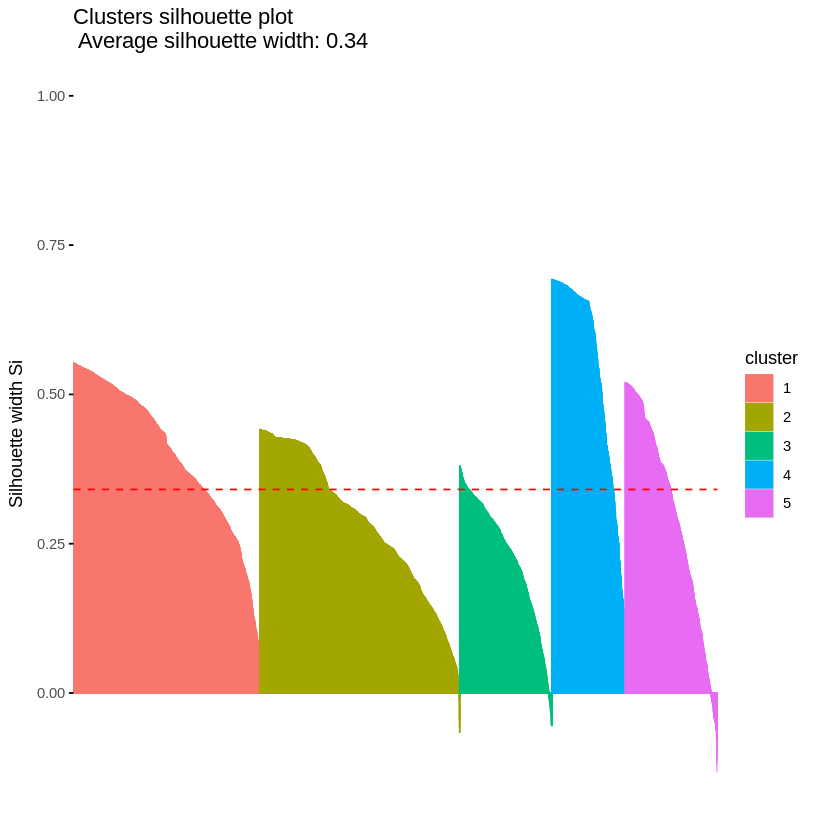

In [49]:
fviz_silhouette(sil)

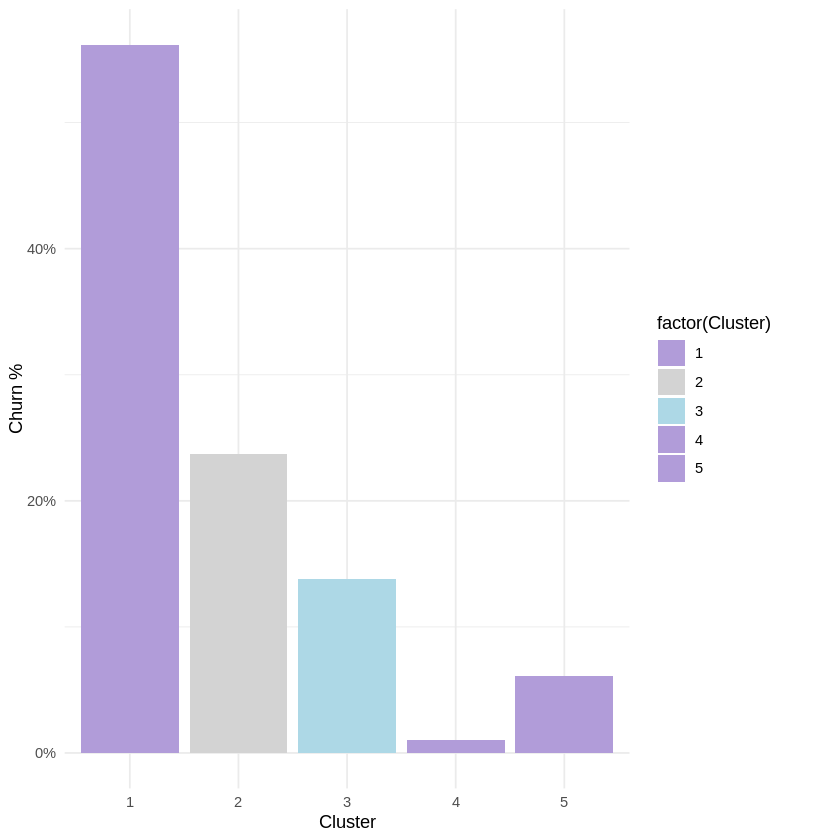

In [50]:
df_sel_clustered5 %>%
  group_by(Cluster) %>%
  summarise(churn_rate = mean(Churn == "Yes")) %>%
  ggplot(aes(x = factor(Cluster), y = churn_rate, fill = factor(Cluster))) +
  geom_col() +
  scale_y_continuous(labels = scales::percent) +
  labs(x = "Cluster", y = "Churn %") +
  scale_fill_manual(values = c("3" = "#ADD8E6", "2" = "#D3D3D3", "1" = "#B19CD9", "4" = "#B19CD9", "5" = "#B19CD9")) +
  theme_minimal()

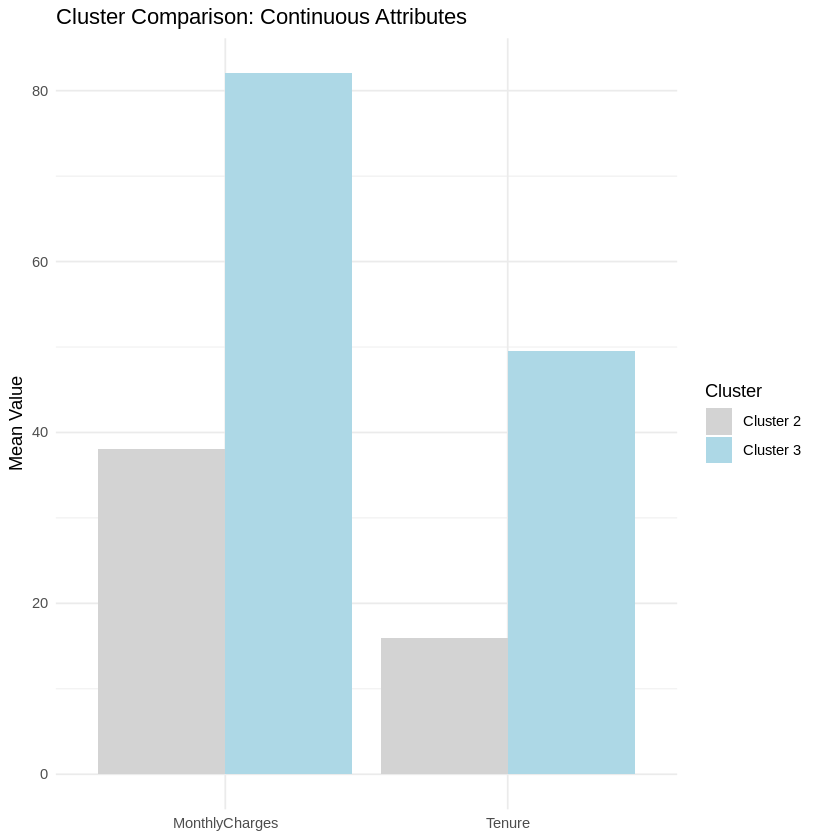

In [51]:
get_means <- function(cid) {
  df[df_sel_clustered5$Cluster == cid, ] %>%
    summarise(
      Tenure = mean(tenure),
      MonthlyCharges = mean(MonthlyCharges),
      TotalCharges = mean(TotalCharges),
      Contract_TwoYear = mean(Contract == "Two year"),
      Contract_OneYear = mean(Contract == "One year"),
      InternetService_Fiber = mean(InternetService == "Fiber optic"),
      Payment_ECheck = mean(PaymentMethod == "Electronic check"),
      OnlineSecurity = mean(OnlineSecurity == "Yes")
    ) %>%
    t() %>%
    as.data.frame() %>%
    tibble::rownames_to_column("Attribute")
}

low_vals <- get_means(low_cid)
high_vals <- get_means(high_cid)

plot_df1 <- rbind(
  data.frame(Attribute = low_vals$Attribute, Value = low_vals$V1, Cluster = paste("Cluster", low_cid)),
  data.frame(Attribute = high_vals$Attribute, Value = high_vals$V1, Cluster = paste("Cluster", high_cid))
) %>% filter(Attribute %in% c("Tenure", "MonthlyCharges"))

ggplot(plot_df1, aes(x = Attribute, y = Value, fill = Cluster)) +
  geom_col(position = "dodge") +
  labs(title = "Cluster Comparison: Continuous Attributes", y = "Mean Value", x = NULL) +
  scale_fill_manual(values = c("Cluster 3" = "#ADD8E6", "Cluster 2" = "#D3D3D3")) +
  theme_minimal()

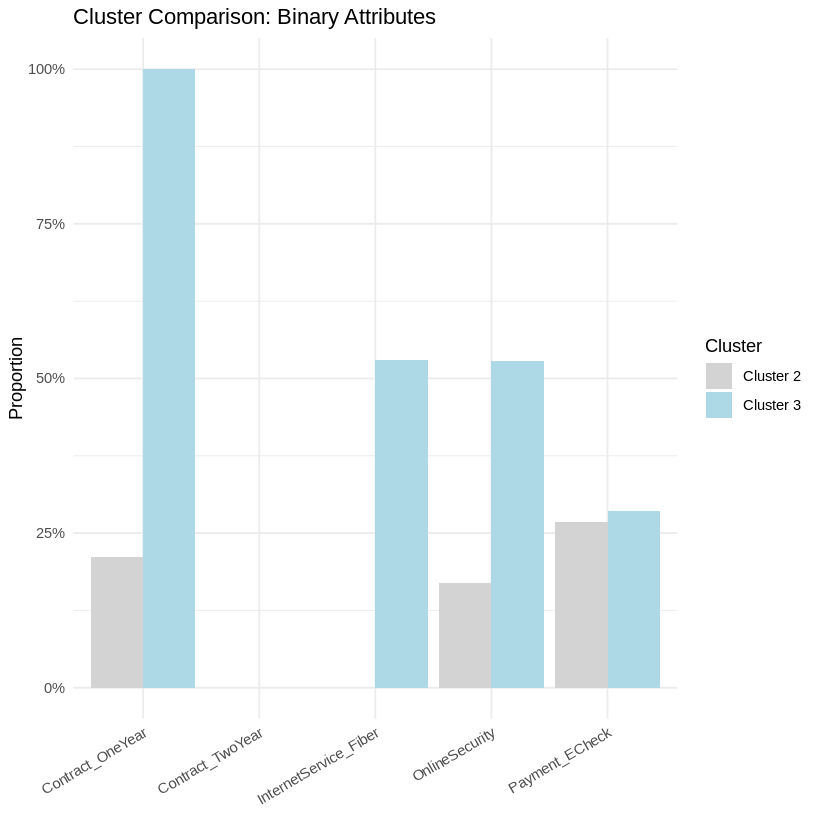

In [52]:
plot_df2 <- rbind(
  data.frame(Attribute = low_vals$Attribute, Value = low_vals$V1, Cluster = paste("Cluster", low_cid)),
  data.frame(Attribute = high_vals$Attribute, Value = high_vals$V1, Cluster = paste("Cluster", high_cid))
) %>% filter(!(Attribute %in% c("Tenure", "MonthlyCharges", "TotalCharges")))

ggplot(plot_df2, aes(x = Attribute, y = Value, fill = Cluster)) +
  geom_col(position = "dodge") +
  scale_y_continuous(labels = scales::percent) +
  labs(title = "Cluster Comparison: Binary Attributes", y = "Proportion", x = NULL) +
  theme_minimal() +
  scale_fill_manual(values = c("Cluster 3" = "#ADD8E6", "Cluster 2" = "#D3D3D3")) +
  theme(axis.text.x = element_text(angle = 30, hjust = 1))

## GMM

In [125]:
GMM25 <- Mclust(feature_scale, G = 5, model = "VII")

In [126]:
GMM25$BIC

Bayesian Information Criterion (BIC): 
        VII
5 -112230.2

Top 3 models based on the BIC criterion: 
    VII,5 
-112230.2 

In [127]:
GMM25$parameters$mean

TotalCharges,0.26767119,-0.4014760,-0.9707752,-0.6239496,-0.7258827
tenure,0.21778708,1.1892667,-1.1601997,-0.8969771,-1.0142851
MonthlyCharges,0.09339661,-1.4176371,-1.4580365,0.5754117,0.6019066
InternetService_Fiber.optic,-0.11765472,-0.8868334,-0.8868334,1.1274471,1.1274471
PaymentMethod_Electronic.check,-0.04155397,-0.7118128,-0.7118128,-0.7118128,1.4046640
Contract_Two.year,0.02768382,1.7812475,-0.5613245,-0.5613245,-0.5613245
Contract_One.year,0.20064212,-0.5145003,-0.5145003,-0.5145003,-0.5145003
OnlineSecurity_Yes,0.24712749,-0.6337013,-0.6337013,-0.6337013,-0.6337013


In [128]:
df_gmm <- df %>%
  mutate(Cluster = factor(GMM25$classification))

df_gmm %>%
  count(Cluster, Churn) %>%
  group_by(Cluster) %>%
  mutate(Percent = round(n / sum(n) * 100, 1)) %>%
  ungroup()

Cluster,Churn,n,Percent
<fct>,<fct>,<int>,<dbl>
1,No,4050,80.0
1,Yes,1010,20.0
2,No,411,99.3
2,Yes,3,0.7
3,No,300,75.9
3,Yes,95,24.1
4,No,171,42.8
4,Yes,229,57.2
5,No,231,30.3


In [129]:
# Compute silhouette widths
sil <- silhouette(GMM25$classification, dist(feature_scale))

# Average silhouette score
mean_sil_width <- mean(sil[, 3])
cat("Average silhouette width:", round(mean_sil_width, 3), "\n")

Average silhouette width: 0.024 


  cluster size ave.sil.width
1       1 5060         -0.27
2       2  414          0.85
3       3  395          0.93
4       4  400          0.70
5       5  763          0.73


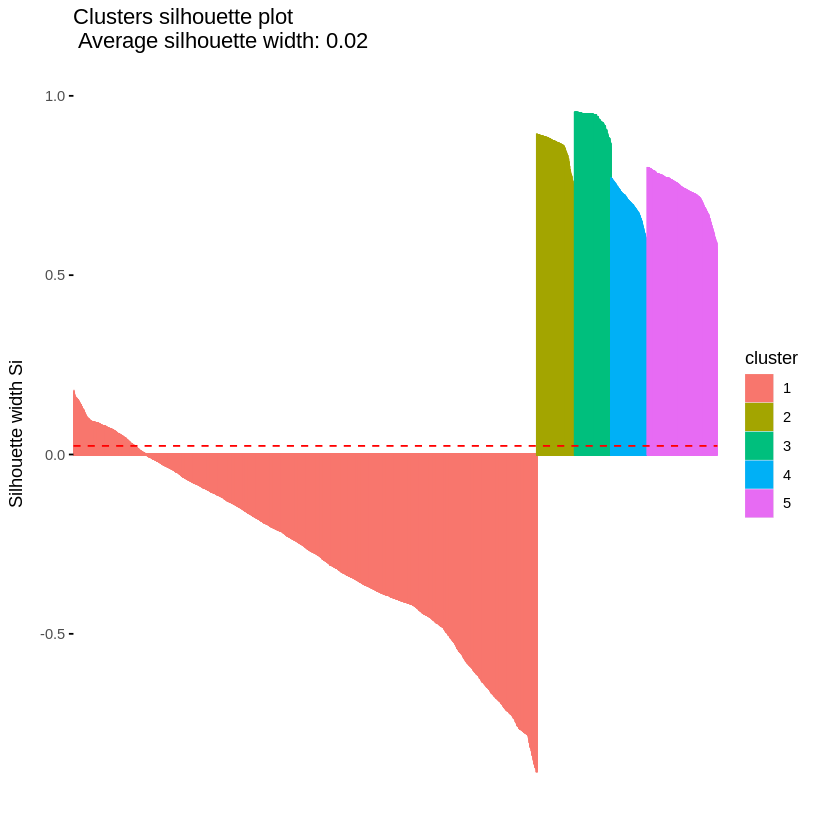

In [130]:
fviz_silhouette(sil)

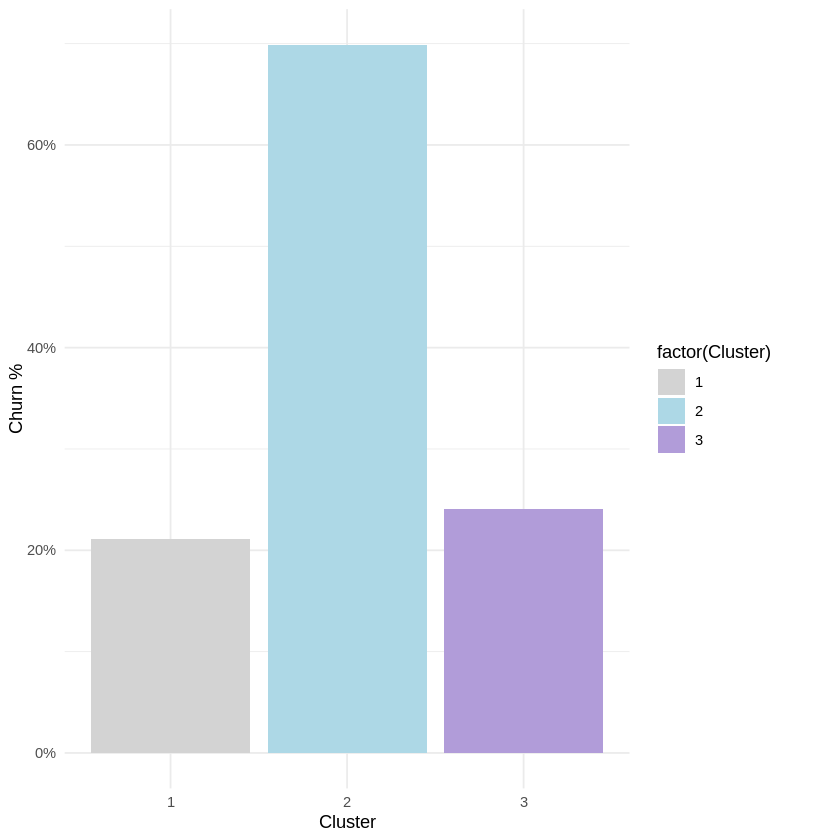

In [59]:
df_gmm %>%
  group_by(Cluster) %>%
  summarise(churn_rate = mean(Churn == "Yes")) %>%
  ggplot(aes(x = factor(Cluster), y = churn_rate, fill = factor(Cluster))) +
  geom_col() +
  scale_y_continuous(labels = scales::percent) +
  labs(x = "Cluster", y = "Churn %") +
  scale_fill_manual(values = c("2" = "#ADD8E6", "1" = "#D3D3D3", "3" = "#B19CD9")) +
  theme_minimal()

In [60]:
# Compute churn % per cluster
df_gmm %>%
  count(Cluster, Churn) %>%
  group_by(Cluster) %>%
  mutate(Perc = n / sum(n)) %>%
  filter(Churn == "Yes") %>%
  arrange(desc(Perc))

# Extract IDs
high_churn_cluster <- 2
low_churn_cluster <- 1

Cluster,Churn,n,Perc
<fct>,<fct>,<int>,<dbl>
2,Yes,532,0.6990802
3,Yes,95,0.2405063
1,Yes,1242,0.2113683


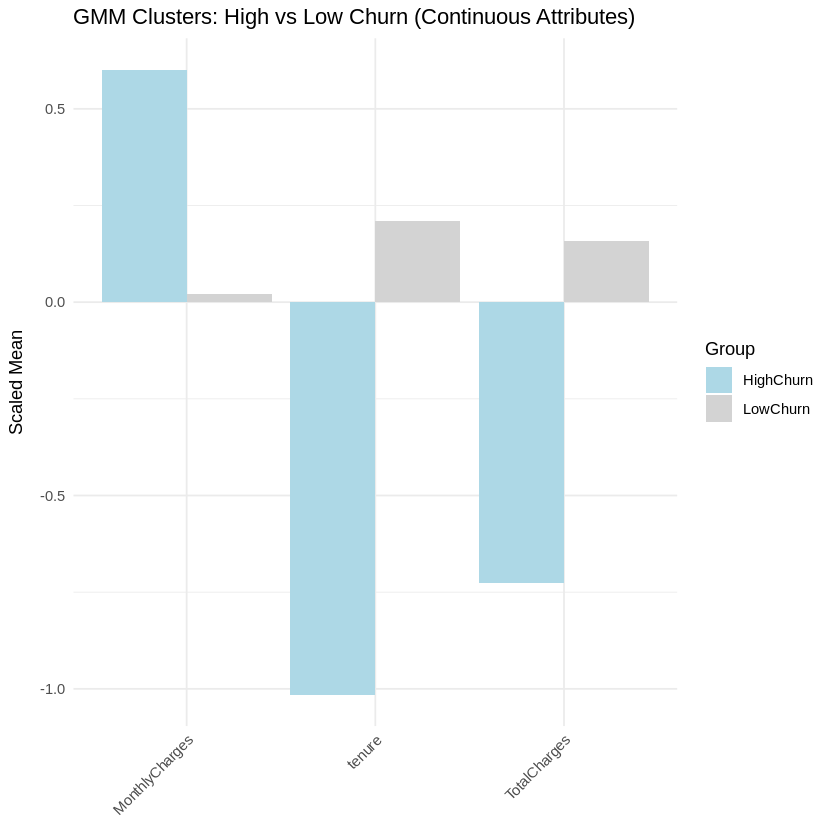

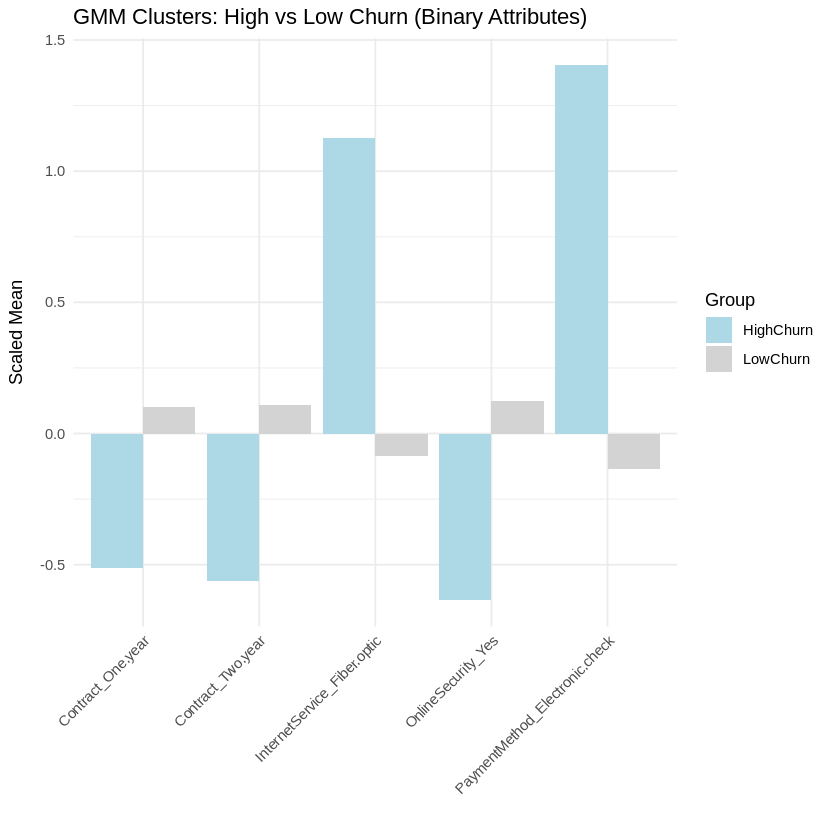

In [61]:
# Extract and reshape GMM means
means <- GMM25$parameters$mean
attr_names <- rownames(means)

plot_df <- data.frame(
  Attribute = attr_names,
  HighChurn = means[, high_churn_cluster],
  LowChurn = means[, low_churn_cluster]
) %>%
  pivot_longer(cols = c("HighChurn", "LowChurn"), names_to = "Group", values_to = "ScaledMean")

# Define your continuous attributes
continuous_attrs <- c("tenure", "MonthlyCharges", "TotalCharges")

ggplot(filter(plot_df, Attribute %in% continuous_attrs),
       aes(x = Attribute, y = ScaledMean, fill = Group)) +
  geom_col(position = "dodge") +
  labs(title = "GMM Clusters: High vs Low Churn (Continuous Attributes)",
       y = "Scaled Mean", x = NULL) +
  theme_minimal() +
  scale_fill_manual(values = c("HighChurn" = "#ADD8E6", "LowChurn" = "#D3D3D3")) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

  # Define your binary attributes
binary_attrs <- c("Contract_Two.year", "Contract_One.year",
                  "InternetService_Fiber.optic",
                  "PaymentMethod_Electronic.check",
                  "OnlineSecurity_Yes")

ggplot(filter(plot_df, Attribute %in% binary_attrs),
       aes(x = Attribute, y = ScaledMean, fill = Group)) +
  geom_col(position = "dodge") +
  labs(title = "GMM Clusters: High vs Low Churn (Binary Attributes)",
       y = "Scaled Mean", x = NULL) +
  theme_minimal() +
  scale_fill_manual(values = c("HighChurn" = "#ADD8E6", "LowChurn" = "#D3D3D3")) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

# Top 20% Feature Select

## Set up

In [62]:
select_features20 <- dplyr::select(
  df_dummy,
  TotalCharges,
  tenure,
  MonthlyCharges,
  InternetService_Fiber.optic,
  PaymentMethod_Electronic.check,
  Contract_Two.year
)

In [63]:
names(select_features20)

[1] "TotalCharges"                   "tenure"                        
[3] "MonthlyCharges"                 "InternetService_Fiber.optic"   
[5] "PaymentMethod_Electronic.check" "Contract_Two.year"

In [64]:
feature_scale20 <- scale(select_features20)

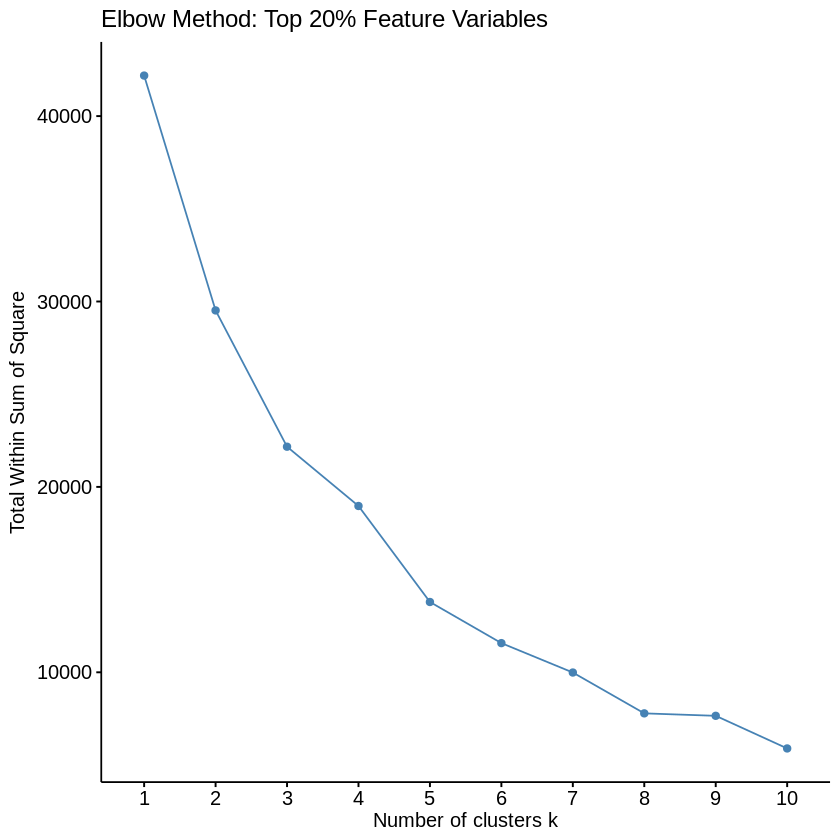

In [65]:
fviz_nbclust(feature_scale20, kmeans, method = "wss") +
  labs(title = "Elbow Method: Top 20% Feature Variables")

In [66]:
km_feature3 <- kmeans(feature_scale20, centers = 3, nstart = 25)

In [67]:
km_feature4 <- kmeans(feature_scale20, centers = 4, nstart = 25)

In [68]:
km_feature5_20 <- kmeans(feature_scale20, centers = 5, nstart = 25)

## 3 centers

In [69]:
df_sel_clustered3 <- df %>%
  mutate(Cluster = factor(km_feature3$cluster))

In [70]:
df_sel_clustered3 %>%
  count(Cluster, Churn) %>%
  group_by(Cluster) %>%
  mutate(Percent = round(n / sum(n) * 100, 1)) %>%
  ungroup()

Cluster,Churn,n,Percent
<fct>,<fct>,<int>,<dbl>
1,No,2729,83.2
1,Yes,550,16.8
2,No,913,45.0
2,Yes,1116,55.0
3,No,1521,88.2
3,Yes,203,11.8


In [71]:
df %>%
  mutate(Cluster = df_sel_clustered3$Cluster) %>%
  group_by(Cluster) %>%
  summarise(
    tenure = mean(tenure),
    MonthlyCharges = mean(MonthlyCharges),
    Contract_TwoYear = mean(Contract == "Two year"),
    InternetService_Fiber.optic = mean(InternetService == "Fiber optic"),
    PaymentMethod_Electronic.check = mean(PaymentMethod == "Electronic check"),
    TotalCharges = mean(TotalCharges),
    .groups = "drop"
  )

Cluster,tenure,MonthlyCharges,Contract_TwoYear,InternetService_Fiber.optic,PaymentMethod_Electronic.check,TotalCharges
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,25.95303,37.68300,0.226898445,0.0000000,0.2028057,943.1518
2,17.59093,86.19505,0.001971414,0.9871858,0.6535239,1573.4763
3,62.17981,91.18834,0.543503480,0.6339907,0.2169374,5667.6278


In [72]:
sil <- silhouette(km_feature3$cluster, dist(feature_scale20))
mean(sil[, 3])

[1] 0.3486929

  cluster size ave.sil.width
1       1 3279          0.33
2       2 2029          0.46
3       3 1724          0.24


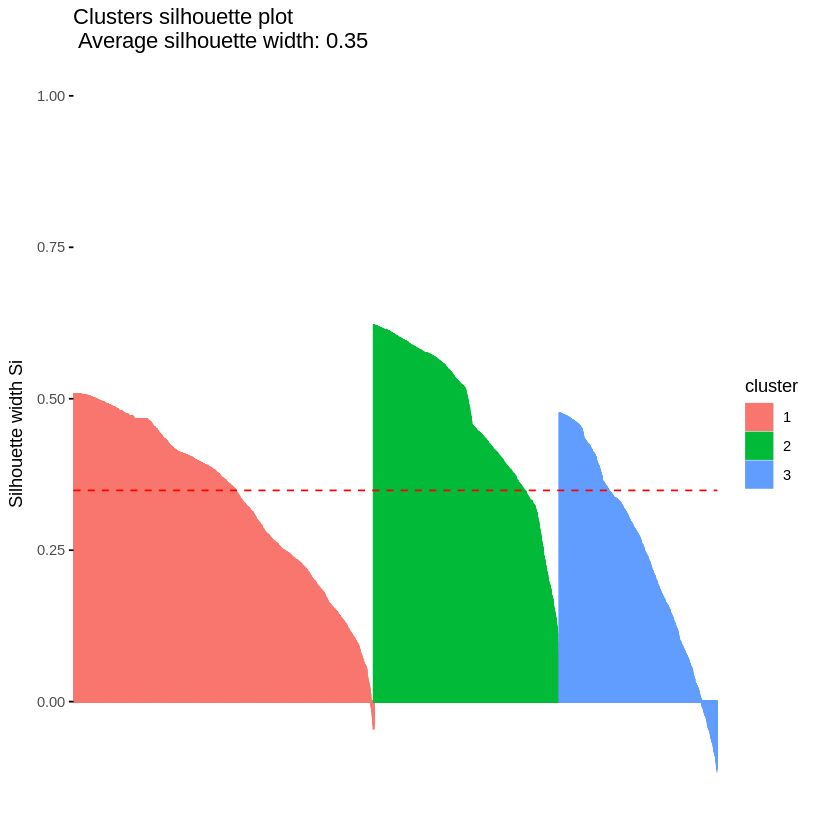

In [73]:
fviz_silhouette(sil)

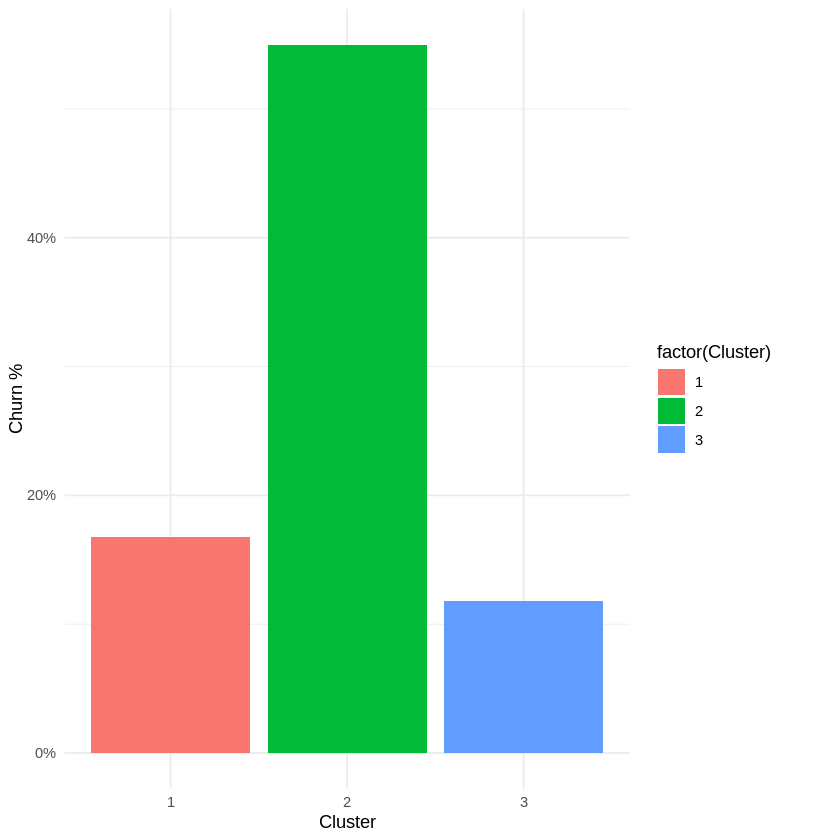

In [74]:
low_cid <- 3
high_cid <- 2

df_sel_clustered3 %>%
  group_by(Cluster) %>%
  summarise(churn_rate = mean(Churn == "Yes")) %>%
  ggplot(aes(x = factor(Cluster), y = churn_rate, fill = factor(Cluster))) +
  geom_col() +
  scale_y_continuous(labels = scales::percent) +
  labs(x = "Cluster", y = "Churn %") +
  theme_minimal()

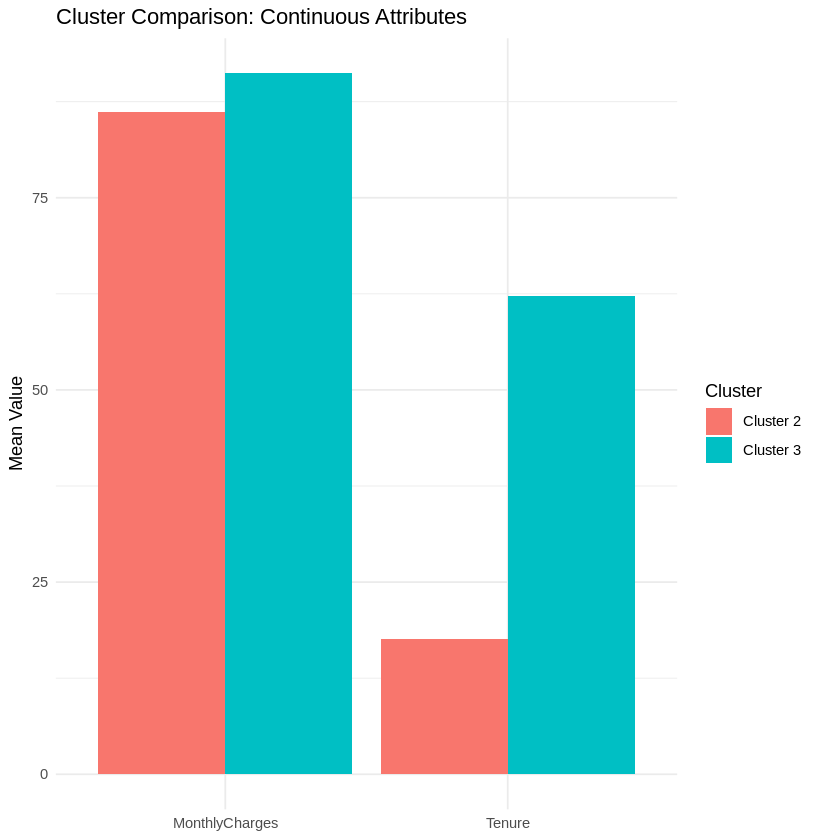

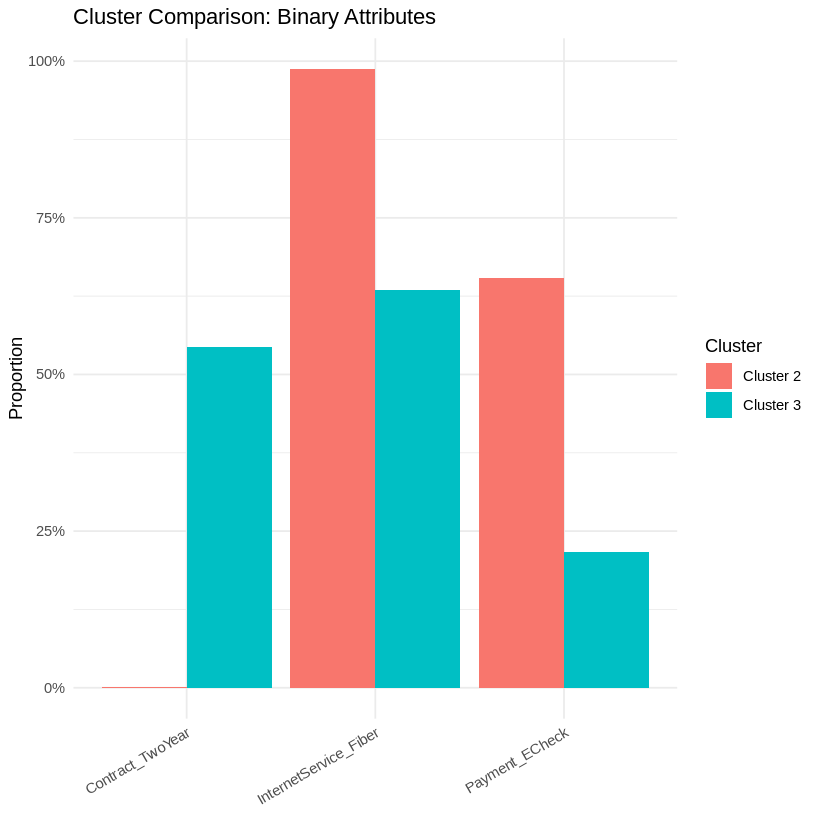

In [75]:
get_means <- function(cid) {
  df[df_sel_clustered3$Cluster == cid, ] %>%
    summarise(
      Tenure = mean(tenure),
      MonthlyCharges = mean(MonthlyCharges),
      TotalCharges = mean(TotalCharges),
      Contract_TwoYear = mean(Contract == "Two year"),
      InternetService_Fiber = mean(InternetService == "Fiber optic"),
      Payment_ECheck = mean(PaymentMethod == "Electronic check")
    ) %>%
    t() %>%
    as.data.frame() %>%
    tibble::rownames_to_column("Attribute")
}

low_vals <- get_means(low_cid)
high_vals <- get_means(high_cid)

plot_df1 <- rbind(
  data.frame(Attribute = low_vals$Attribute, Value = low_vals$V1, Cluster = paste("Cluster", low_cid)),
  data.frame(Attribute = high_vals$Attribute, Value = high_vals$V1, Cluster = paste("Cluster", high_cid))
) %>% filter(Attribute %in% c("Tenure", "MonthlyCharges"))

ggplot(plot_df1, aes(x = Attribute, y = Value, fill = Cluster)) +
  geom_col(position = "dodge") +
  labs(title = "Cluster Comparison: Continuous Attributes", y = "Mean Value", x = NULL) +
  theme_minimal()

plot_df2 <- rbind(
  data.frame(Attribute = low_vals$Attribute, Value = low_vals$V1, Cluster = paste("Cluster", low_cid)),
  data.frame(Attribute = high_vals$Attribute, Value = high_vals$V1, Cluster = paste("Cluster", high_cid))
) %>% filter(!(Attribute %in% c("Tenure", "MonthlyCharges", "TotalCharges")))

ggplot(plot_df2, aes(x = Attribute, y = Value, fill = Cluster)) +
  geom_col(position = "dodge") +
  scale_y_continuous(labels = scales::percent) +
  labs(title = "Cluster Comparison: Binary Attributes", y = "Proportion", x = NULL) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 30, hjust = 1))

## 4 clusters

In [76]:
df_sel_clustered4 <- df %>%
  mutate(Cluster = factor(km_feature4$cluster))

In [77]:
df_sel_clustered4 %>%
  count(Cluster, Churn) %>%
  group_by(Cluster) %>%
  mutate(Percent = round(n / sum(n) * 100, 1)) %>%
  ungroup()

Cluster,Churn,n,Percent
<fct>,<fct>,<int>,<dbl>
1,No,1097,81.1
1,Yes,255,18.9
2,No,1238,98.6
2,Yes,17,1.4
3,No,2052,78.9
3,Yes,550,21.1
4,No,776,42.6
4,Yes,1047,57.4


In [78]:
df %>%
  mutate(Cluster = df_sel_clustered4$Cluster) %>%
  group_by(Cluster) %>%
  summarise(
    tenure = mean(tenure),
    MonthlyCharges = mean(MonthlyCharges),
    Contract_TwoYear = mean(Contract == "Two year"),
    InternetService_Fiber.optic = mean(InternetService == "Fiber optic"),
    PaymentMethod_Electronic.check = mean(PaymentMethod == "Electronic check"),
    TotalCharges = mean(TotalCharges),
    .groups = "drop"
  )

Cluster,tenure,MonthlyCharges,Contract_TwoYear,InternetService_Fiber.optic,PaymentMethod_Electronic.check,TotalCharges
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,58.95636,98.90263,0.3173076923,0.940088757,0.32322485,5854.0860
2,54.28765,45.83841,0.9968127490,0.001593625,0.05498008,2657.4826
3,20.33513,41.78884,0.0003843198,0.000000000,0.25941583,925.2986
4,14.94131,85.39929,0.0021941854,1.000000000,0.64947888,1315.7854


In [79]:
sil <- silhouette(km_feature4$cluster, dist(feature_scale20))
mean(sil[, 3])

[1] 0.3933671

  cluster size ave.sil.width
1       1 1352          0.28
2       2 1255          0.40
3       3 2602          0.40
4       4 1823          0.46


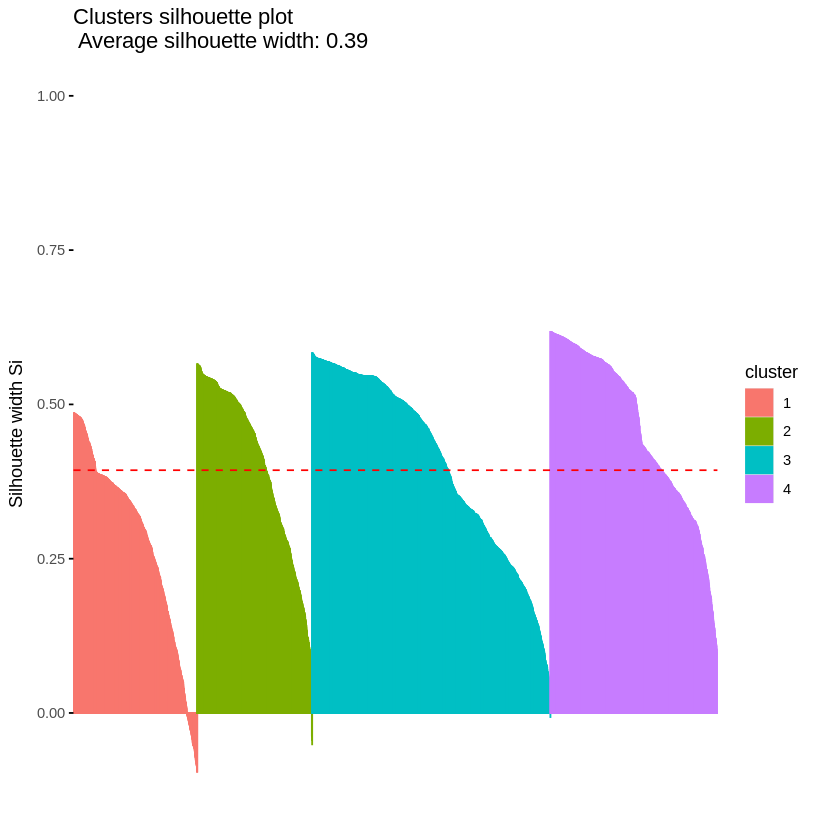

In [80]:
fviz_silhouette(sil)

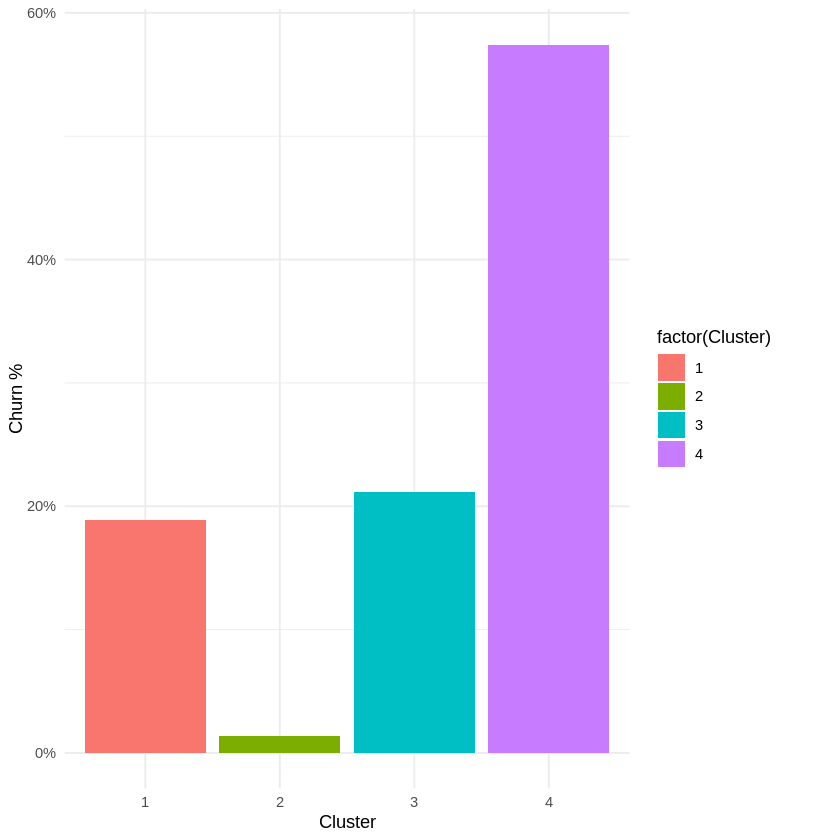

In [81]:
low_cid <- 4
high_cid <- 3

df_sel_clustered4 %>%
  group_by(Cluster) %>%
  summarise(churn_rate = mean(Churn == "Yes")) %>%
  ggplot(aes(x = factor(Cluster), y = churn_rate, fill = factor(Cluster))) +
  geom_col() +
  scale_y_continuous(labels = scales::percent) +
  labs(x = "Cluster", y = "Churn %") +
  theme_minimal()

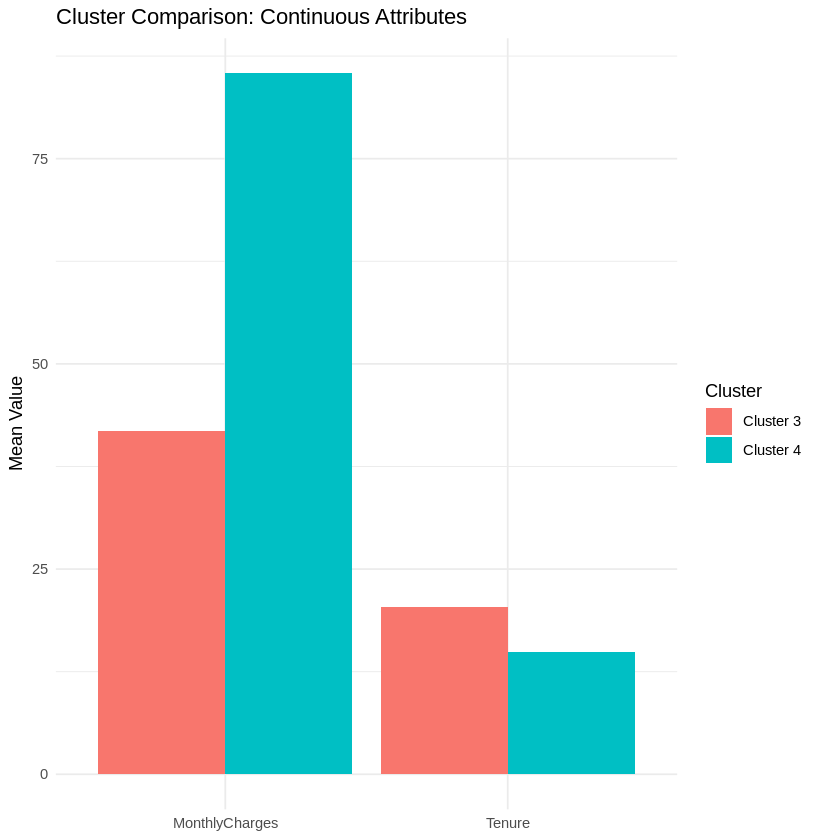

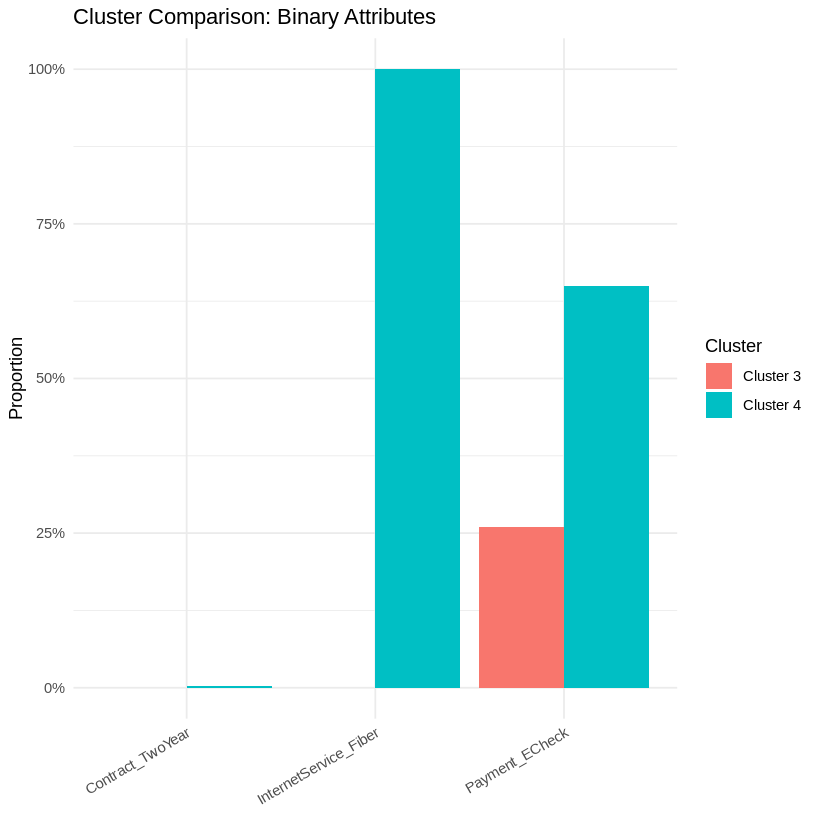

In [82]:
get_means <- function(cid) {
  df[df_sel_clustered4$Cluster == cid, ] %>%
    summarise(
      Tenure = mean(tenure),
      MonthlyCharges = mean(MonthlyCharges),
      TotalCharges = mean(TotalCharges),
      Contract_TwoYear = mean(Contract == "Two year"),
      InternetService_Fiber = mean(InternetService == "Fiber optic"),
      Payment_ECheck = mean(PaymentMethod == "Electronic check")
    ) %>%
    t() %>%
    as.data.frame() %>%
    tibble::rownames_to_column("Attribute")
}

low_vals <- get_means(low_cid)
high_vals <- get_means(high_cid)

plot_df1 <- rbind(
  data.frame(Attribute = low_vals$Attribute, Value = low_vals$V1, Cluster = paste("Cluster", low_cid)),
  data.frame(Attribute = high_vals$Attribute, Value = high_vals$V1, Cluster = paste("Cluster", high_cid))
) %>% filter(Attribute %in% c("Tenure", "MonthlyCharges"))

ggplot(plot_df1, aes(x = Attribute, y = Value, fill = Cluster)) +
  geom_col(position = "dodge") +
  labs(title = "Cluster Comparison: Continuous Attributes", y = "Mean Value", x = NULL) +
  theme_minimal()

plot_df2 <- rbind(
  data.frame(Attribute = low_vals$Attribute, Value = low_vals$V1, Cluster = paste("Cluster", low_cid)),
  data.frame(Attribute = high_vals$Attribute, Value = high_vals$V1, Cluster = paste("Cluster", high_cid))
) %>% filter(!(Attribute %in% c("Tenure", "MonthlyCharges", "TotalCharges")))

ggplot(plot_df2, aes(x = Attribute, y = Value, fill = Cluster)) +
  geom_col(position = "dodge") +
  scale_y_continuous(labels = scales::percent) +
  labs(title = "Cluster Comparison: Binary Attributes", y = "Proportion", x = NULL) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 30, hjust = 1))

## 5 centers

In [83]:
df_sel_clustered5_20 <- df %>%
  mutate(Cluster = factor(km_feature5_20$cluster))

In [84]:
df_sel_clustered5_20 %>%
  count(Cluster, Churn) %>%
  group_by(Cluster) %>%
  mutate(Percent = round(n / sum(n) * 100, 1)) %>%
  ungroup()

Cluster,Churn,n,Percent
<fct>,<fct>,<int>,<dbl>
1,No,889,75.3
1,Yes,291,24.7
2,No,657,40.1
2,Yes,982,59.9
3,No,757,95.2
3,Yes,38,4.8
4,No,876,98.9
4,Yes,10,1.1
5,No,1984,78.4


In [85]:
df %>%
  mutate(Cluster = df_sel_clustered5_20$Cluster) %>%
  group_by(Cluster) %>%
  summarise(
    tenure = mean(tenure),
    MonthlyCharges = mean(MonthlyCharges),
    Contract_TwoYear = mean(Contract == "Two year"),
    InternetService_Fiber.optic = mean(InternetService == "Fiber optic"),
    PaymentMethod_Electronic.check = mean(PaymentMethod == "Electronic check"),
    TotalCharges = mean(TotalCharges),
    .groups = "drop"
  )

Cluster,tenure,MonthlyCharges,Contract_TwoYear,InternetService_Fiber.optic,PaymentMethod_Electronic.check,TotalCharges
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,52.61695,93.77314,0.000000000,0.8754237,0.36355932,4937.2976
2,12.66809,84.79170,0.002440513,0.9993899,0.68151312,1106.6582
3,66.12704,93.02132,1.000000000,0.5345912,0.15597484,6149.7450
4,49.08239,31.84893,1.000000000,0.0000000,0.04514673,1561.3894
5,19.38428,41.02093,0.000000000,0.0000000,0.25868878,846.7245


In [86]:
sil <- silhouette(km_feature5_20$cluster, dist(feature_scale20))
mean(sil[, 3])

[1] 0.3979448

  cluster size ave.sil.width
1       1 1180          0.29
2       2 1639          0.46
3       3  795          0.34
4       4  886          0.50
5       5 2532          0.39


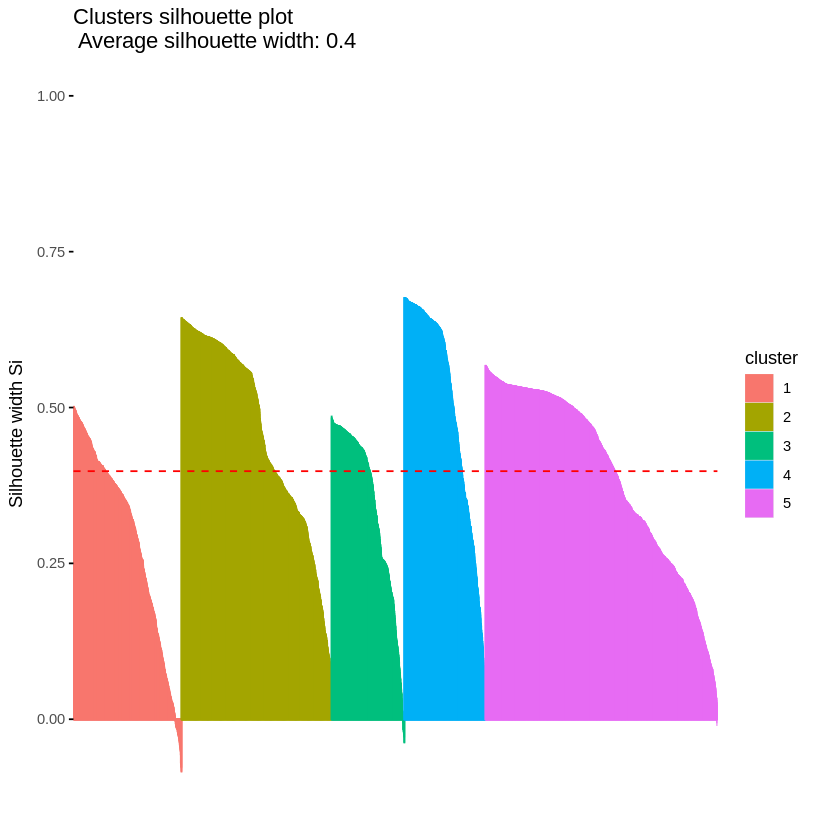

In [87]:
fviz_silhouette(sil)

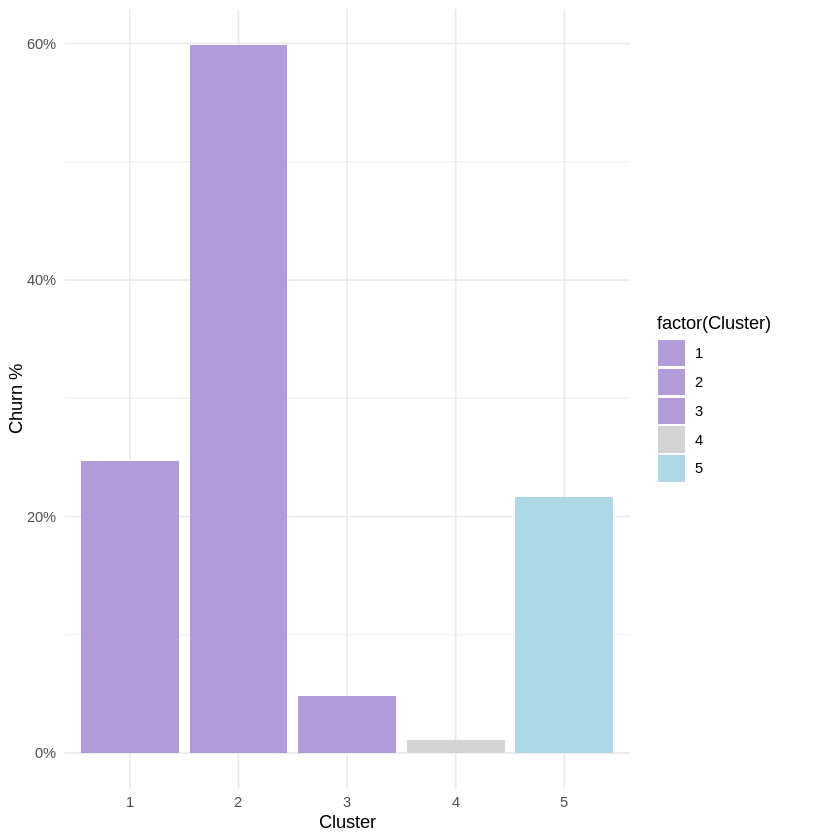

In [88]:
low_cid <- 4
high_cid <- 5

df_sel_clustered5_20 %>%
  group_by(Cluster) %>%
  summarise(churn_rate = mean(Churn == "Yes")) %>%
  ggplot(aes(x = factor(Cluster), y = churn_rate, fill = factor(Cluster))) +
  geom_col() +
  scale_y_continuous(labels = scales::percent) +
  labs(x = "Cluster", y = "Churn %") +
  scale_fill_manual(values = c("5" = "#ADD8E6", "4" = "#D3D3D3", "1" = "#B19CD9", "2" = "#B19CD9", "3" = "#B19CD9")) +
  theme_minimal()

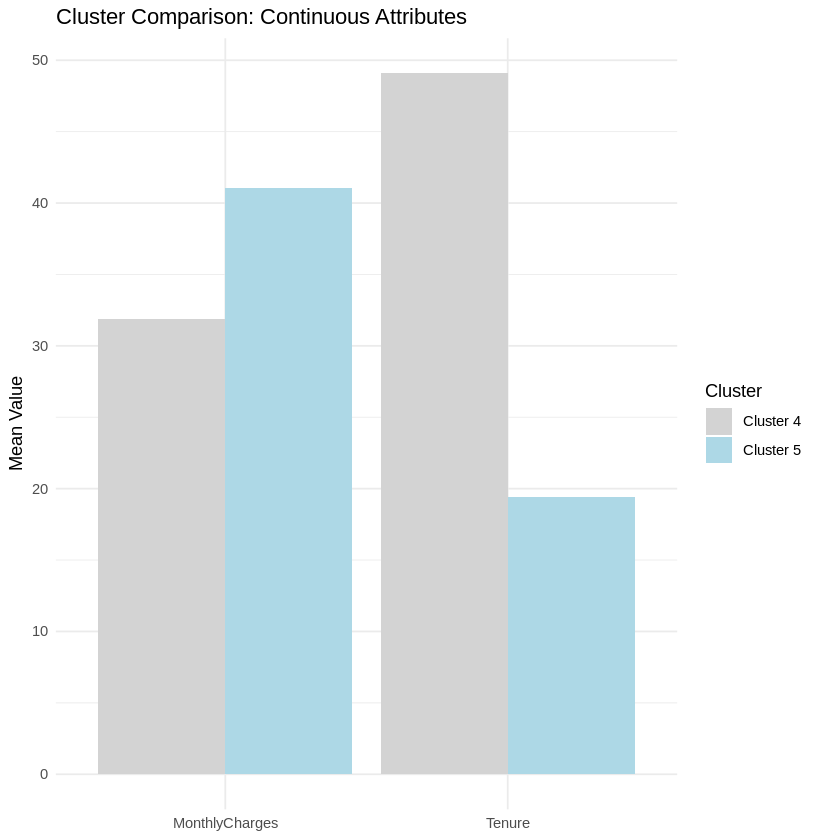

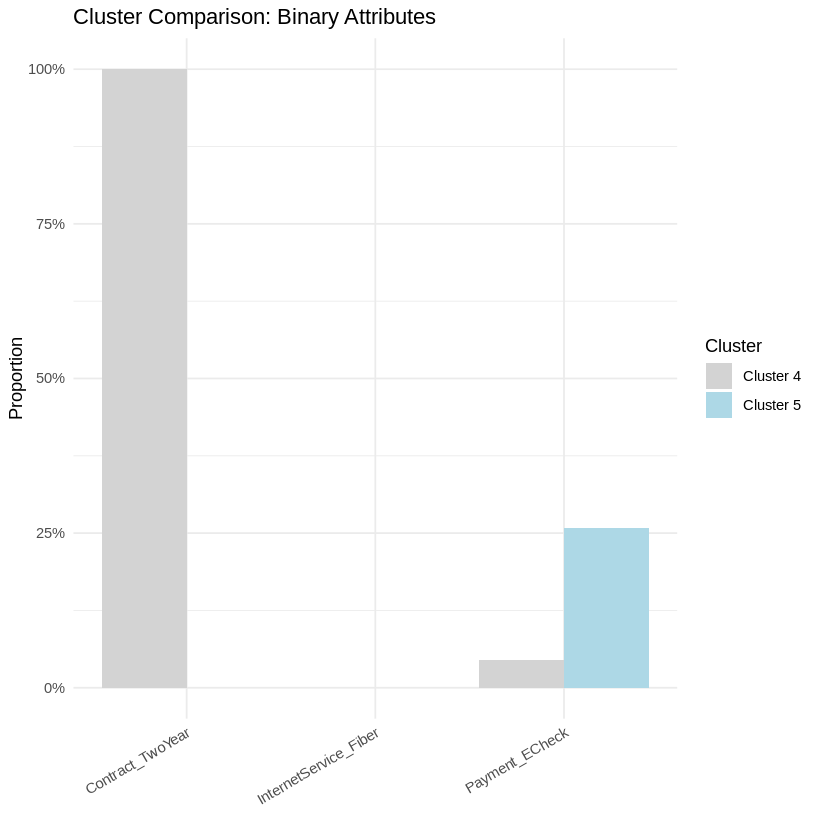

In [89]:
get_means <- function(cid) {
  df[df_sel_clustered5_20$Cluster == cid, ] %>%
    summarise(
      Tenure = mean(tenure),
      MonthlyCharges = mean(MonthlyCharges),
      TotalCharges = mean(TotalCharges),
      Contract_TwoYear = mean(as.character(Contract) == "Two year"),
      InternetService_Fiber = mean(InternetService == "Fiber optic"),
      Payment_ECheck = mean(PaymentMethod == "Electronic check")
    ) %>%
    t() %>%
    as.data.frame() %>%
    tibble::rownames_to_column("Attribute")
}

low_vals <- get_means(low_cid)
high_vals <- get_means(high_cid)

plot_df1 <- rbind(
  data.frame(Attribute = low_vals$Attribute, Value = low_vals$V1, Cluster = paste("Cluster", low_cid)),
  data.frame(Attribute = high_vals$Attribute, Value = high_vals$V1, Cluster = paste("Cluster", high_cid))
) %>% filter(Attribute %in% c("Tenure", "MonthlyCharges"))

ggplot(plot_df1, aes(x = Attribute, y = Value, fill = Cluster)) +
  geom_col(position = "dodge") +
  labs(title = "Cluster Comparison: Continuous Attributes", y = "Mean Value", x = NULL) +
  scale_fill_manual(values = c("Cluster 5" = "#ADD8E6", "Cluster 4" = "#D3D3D3")) +
  theme_minimal()

plot_df2 <- rbind(
  data.frame(Attribute = low_vals$Attribute, Value = low_vals$V1, Cluster = paste("Cluster", low_cid)),
  data.frame(Attribute = high_vals$Attribute, Value = high_vals$V1, Cluster = paste("Cluster", high_cid))
) %>% filter(!(Attribute %in% c("Tenure", "MonthlyCharges", "TotalCharges")))

ggplot(plot_df2, aes(x = Attribute, y = Value, fill = Cluster)) +
  geom_col(position = "dodge") +
  scale_y_continuous(labels = scales::percent) +
  labs(title = "Cluster Comparison: Binary Attributes", y = "Proportion", x = NULL) +
  theme_minimal() +
  scale_fill_manual(values = c("Cluster 5" = "#ADD8E6", "Cluster 4" = "#D3D3D3")) +
  theme(axis.text.x = element_text(angle = 30, hjust = 1))

## GMM

In [90]:
GMM20 <- Mclust(feature_scale20, G = 3, model = "VII")

In [91]:
GMM20$BIC

Bayesian Information Criterion (BIC): 
       VII
3 -95909.9

Top 3 models based on the BIC criterion: 
   VII,3 
-95909.9 

In [92]:
GMM20$parameters$mean

TotalCharges,-0.7077528,0.22422477,-0.9319097
tenure,-0.9966658,0.27808544,-1.0045135
MonthlyCharges,0.6194940,0.07750773,-1.4213357
InternetService_Fiber.optic,1.1274471,-0.06697883,-0.8868334
PaymentMethod_Electronic.check,1.4046640,-0.13155266,-0.7118128
Contract_Two.year,-0.5613245,0.15607746,-0.5613245


In [93]:
df_gmm20 <- df %>%
  mutate(Cluster = factor(GMM20$classification))

df_gmm20 %>%
  count(Cluster, Churn) %>%
  group_by(Cluster) %>%
  mutate(Percent = round(n / sum(n) * 100, 1)) %>%
  ungroup()

Cluster,Churn,n,Percent
<fct>,<fct>,<int>,<dbl>
1,No,278,32.5
1,Yes,578,67.5
2,No,4337,78.8
2,Yes,1165,21.2
3,No,548,81.3
3,Yes,126,18.7


In [94]:
# Compute silhouette widths
sil <- silhouette(GMM20$classification, dist(feature_scale))

# Average silhouette score
mean_sil_width <- mean(sil[, 3])
cat("Average silhouette width:", round(mean_sil_width, 3), "\n")

Average silhouette width: 0.038 


  cluster size ave.sil.width
1       1  856          0.75
2       2 5502         -0.15
3       3  674          0.67


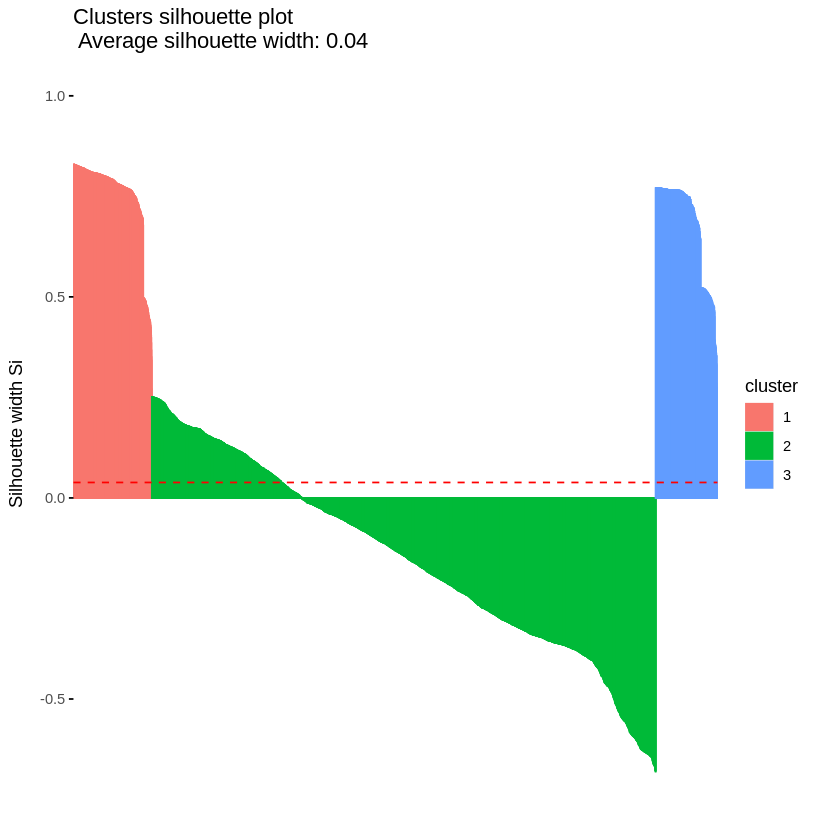

In [95]:
fviz_silhouette(sil)

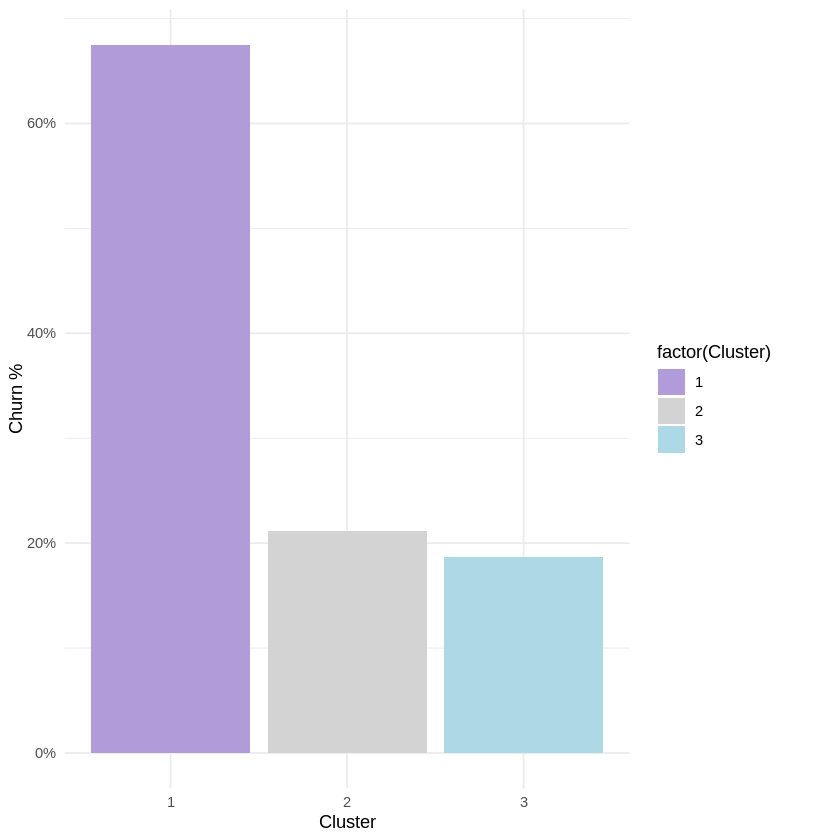

In [96]:
df_gmm20 %>%
  group_by(Cluster) %>%
  summarise(churn_rate = mean(Churn == "Yes")) %>%
  ggplot(aes(x = factor(Cluster), y = churn_rate, fill = factor(Cluster))) +
  geom_col() +
  scale_y_continuous(labels = scales::percent) +
  labs(x = "Cluster", y = "Churn %") +
  scale_fill_manual(values = c("3" = "#ADD8E6", "2" = "#D3D3D3", "1" = "#B19CD9")) +
  theme_minimal()

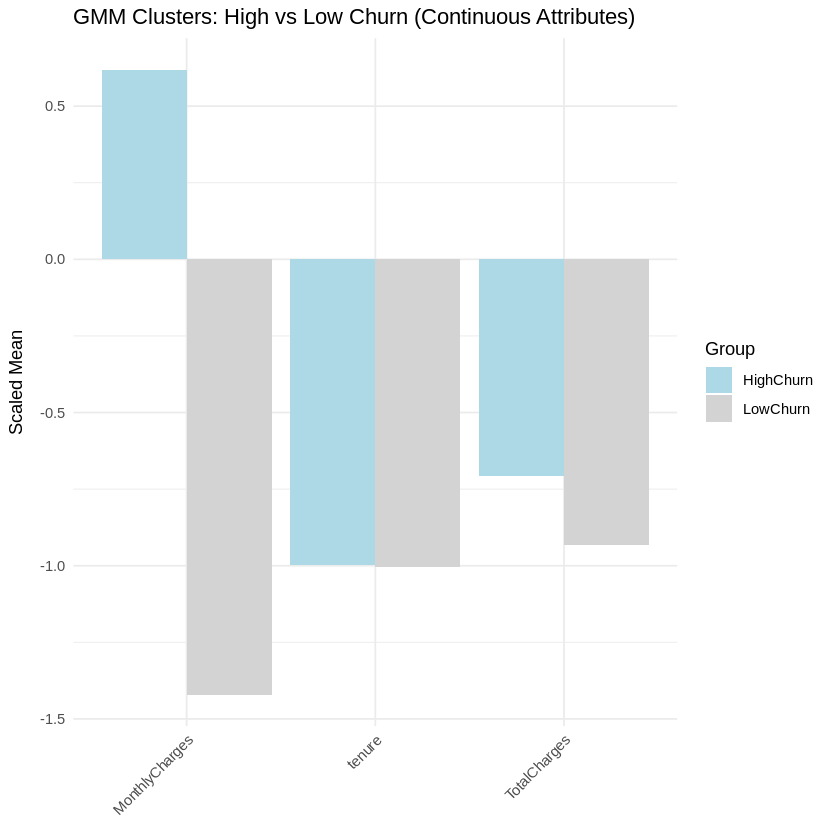

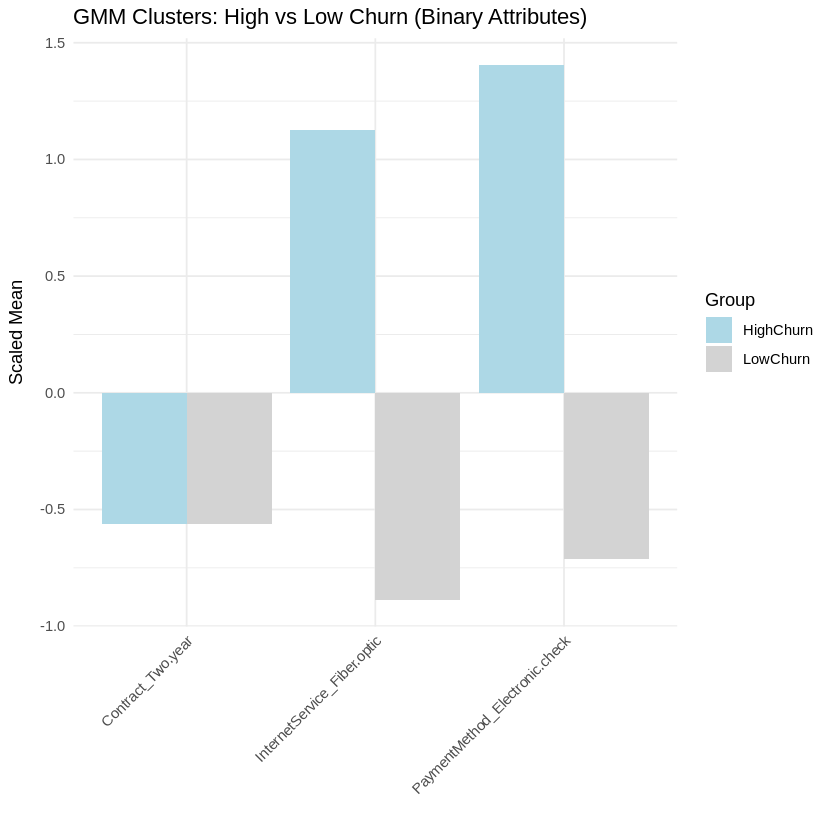

In [124]:
high_churn_cluster <- 1
low_churn_cluster <- 3

# Extract and reshape GMM means
means <- GMM20$parameters$mean
attr_names <- rownames(means)

plot_df <- data.frame(
  Attribute = attr_names,
  HighChurn = means[, high_churn_cluster],
  LowChurn = means[, low_churn_cluster]
) %>%
  pivot_longer(cols = c("HighChurn", "LowChurn"), names_to = "Group", values_to = "ScaledMean")

# Define your continuous attributes
continuous_attrs <- c("tenure", "MonthlyCharges", "TotalCharges")

ggplot(filter(plot_df, Attribute %in% continuous_attrs),
       aes(x = Attribute, y = ScaledMean, fill = Group)) +
  geom_col(position = "dodge") +
  labs(title = "GMM Clusters: High vs Low Churn (Continuous Attributes)",
       y = "Scaled Mean", x = NULL) +
  theme_minimal() +
  scale_fill_manual(values = c("HighChurn" = "#ADD8E6", "LowChurn" = "#D3D3D3")) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

  # Define your binary attributes
binary_attrs <- c("Contract_Two.year", "Contract_One.year",
                  "InternetService_Fiber.optic",
                  "PaymentMethod_Electronic.check",
                  "OnlineSecurity_Yes")

ggplot(filter(plot_df, Attribute %in% binary_attrs),
       aes(x = Attribute, y = ScaledMean, fill = Group)) +
  geom_col(position = "dodge") +
  labs(title = "GMM Clusters: High vs Low Churn (Binary Attributes)",
       y = "Scaled Mean", x = NULL) +
  theme_minimal() +
  scale_fill_manual(values = c("HighChurn" = "#ADD8E6", "LowChurn" = "#D3D3D3")) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

# PCA

In [ ]:
# PCA into Clustering

# Select top 10 features
top_features <- df_dummy %>%
  dplyr::select(TotalCharges, tenure, MonthlyCharges,
                InternetService_Fiber.optic, PaymentMethod_Electronic.check,
                Contract_Two.year, OnlineSecurity_Yes, Contract_One.year,
                gender_Male, TechSupport_Yes)

In [99]:
scaled_features <- scale(df_scaled)

In [100]:
pca_res <- prcomp(df_scaled, center = TRUE, scale. = TRUE)

summary(pca_res)

Importance of components:
                          PC1    PC2     PC3     PC4     PC5     PC6     PC7
Standard deviation     3.1541 1.8981 1.64449 1.19436 1.11486 1.11184 1.06985
Proportion of Variance 0.3316 0.1201 0.09015 0.04755 0.04143 0.04121 0.03815
Cumulative Proportion  0.3316 0.4517 0.54184 0.58939 0.63082 0.67202 0.71018
                           PC8     PC9    PC10   PC11   PC12    PC13    PC14
Standard deviation     1.00052 0.96794 0.94143 0.8932 0.8449 0.82148 0.78535
Proportion of Variance 0.03337 0.03123 0.02954 0.0266 0.0238 0.02249 0.02056
Cumulative Proportion  0.74354 0.77477 0.80432 0.8309 0.8547 0.87720 0.89776
                          PC15    PC16    PC17    PC18    PC19    PC20    PC21
Standard deviation     0.77939 0.72427 0.68307 0.67648 0.66343 0.52633 0.48509
Proportion of Variance 0.02025 0.01749 0.01555 0.01525 0.01467 0.00923 0.00784
Cumulative Proportion  0.91801 0.93550 0.95105 0.96630 0.98098 0.99021 0.99805
                          PC22    PC23    

In [101]:
# Take top 4 PC's, with std > 1: Kaiser Rule
pc_data <- pca_res$x[, 1:8]

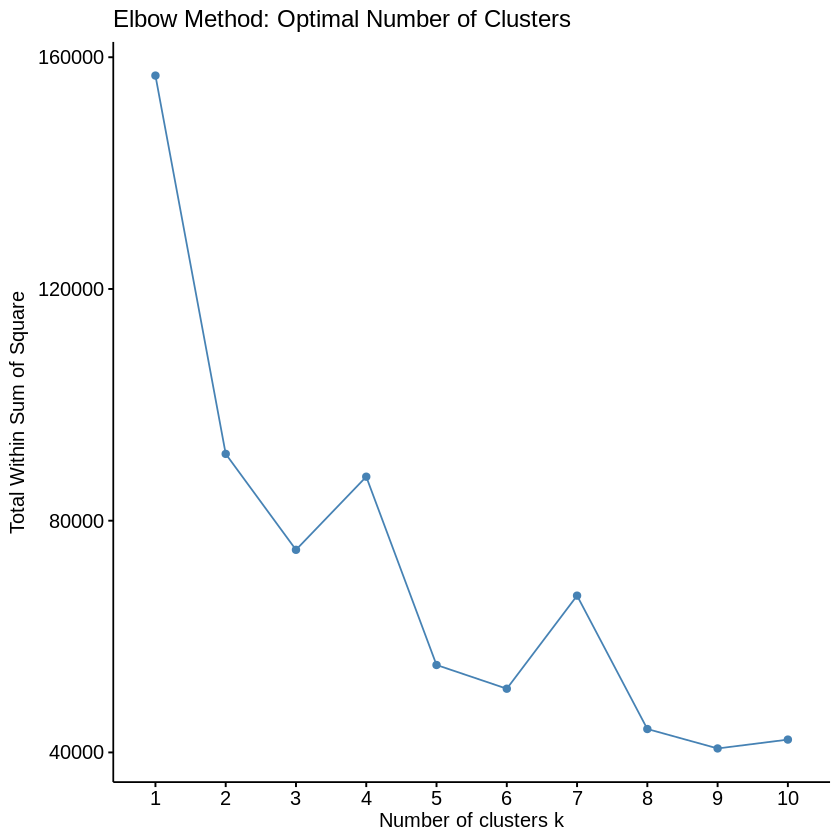

In [102]:
fviz_nbclust(pc_data, kmeans, method = "wss") +
  labs(title = "Elbow Method: Optimal Number of Clusters")

In [103]:
# Clustering based on top PC's
km_res <- kmeans(pc_data, centers = 5, nstart = 25)

In [104]:
df_clusters <- df %>%
  mutate(Cluster = factor(km_res$cluster))

df_clusters %>%
  count(Cluster, Churn) %>%
  group_by(Cluster) %>%
  mutate(Percent = round(100 * n / sum(n), 1)) %>%
  ungroup() %>%
  arrange(Cluster, desc(Churn)) %>%
  print(n = Inf)

# A tibble: 10 × 4
   Cluster Churn     n Percent
   <fct>   <fct> <int>   <dbl>
 1 1       Yes     113     7.4
 2 1       No     1407    92.6
 3 2       Yes     972    57.6
 4 2       No      716    42.4
 5 3       Yes     219    12.5
 6 3       No     1532    87.5
 7 4       Yes     395    28.4
 8 4       No      998    71.6
 9 5       Yes     170    25  
10 5       No      510    75  


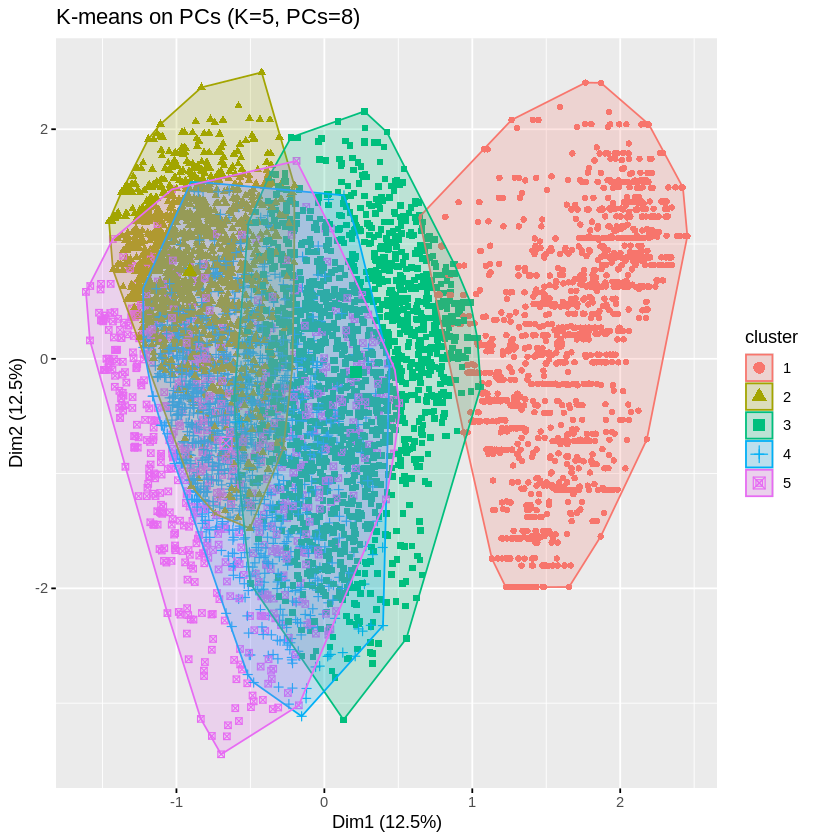

In [115]:
fviz_cluster(km_res, data = pc_data, geom = "point") +
  ggplot2::labs(title = paste0("K-means on PCs (K=", 5, ", PCs=", paste(8, collapse = ","), ")"))

In [106]:
# Sil score
sil <- silhouette(km_res$cluster, dist(pc_data))

mean_sil_width <- mean(sil[, 3])
cat("Average silhouette width:", round(mean_sil_width, 3), "\n")

Average silhouette width: 0.283 


  cluster size ave.sil.width
1       1 1520          0.53
2       2 1688          0.28
3       3 1751          0.18
4       4 1393          0.14
5       5  680          0.31


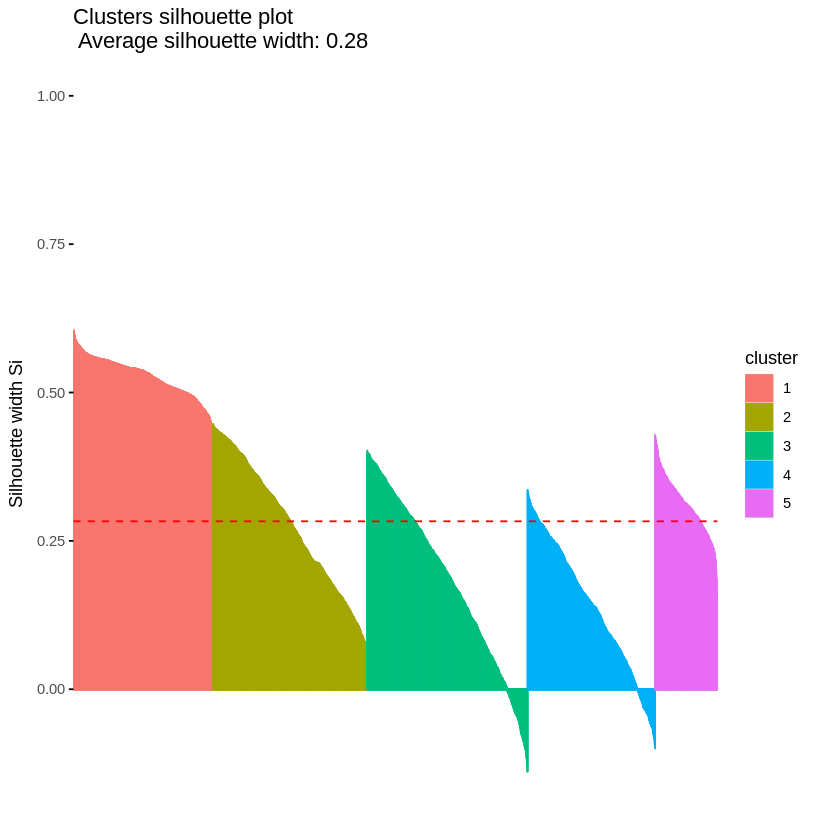

In [107]:
fviz_silhouette(sil)

In [114]:
# GMM with PCA
gmm_pca <- Mclust(pc_data, G = 3, model = "VII")

In [116]:
gmm_pca$BIC

Bayesian Information Criterion (BIC): 
        VII
3 -186646.4

Top 3 models based on the BIC criterion: 
    VII,3 
-186646.4 

In [117]:
gmm_pca$parameters$mean

PC1,-5.72779619,0.908773531,1.673855004
PC2,0.80653621,-1.281726640,-0.073406991
PC3,0.34353533,-4.226506235,0.486448207
PC4,-0.27083087,-1.544829585,0.302488534
PC5,0.07574387,0.024009129,-0.027202485
PC6,0.09341443,0.177657456,-0.054373215
PC7,-0.11120884,-0.130022012,0.053269983
PC8,-0.01259547,-0.009369414,0.005279836


In [118]:
df_gmm_pca <- df %>%
  mutate(Cluster = factor(gmm_pca$classification))

df_gmm_pca %>%
  count(Cluster, Churn) %>%
  group_by(Cluster) %>%
  mutate(Percent = round(n / sum(n) * 100, 1)) %>%
  ungroup()

Cluster,Churn,n,Percent
<fct>,<fct>,<int>,<dbl>
1,No,1407,92.6
1,Yes,113,7.4
2,No,510,75.0
2,Yes,170,25.0
3,No,3246,67.2
3,Yes,1586,32.8


In [119]:
# Sil score
sil <- silhouette(gmm_pca$classification, dist(pc_data))

mean_sil_width <- mean(sil[, 3])
cat("Average silhouette width:", round(mean_sil_width, 3), "\n")

Average silhouette width: 0.392 


  cluster size ave.sil.width
1       1 1520          0.57
2       2  680          0.38
3       3 4832          0.34


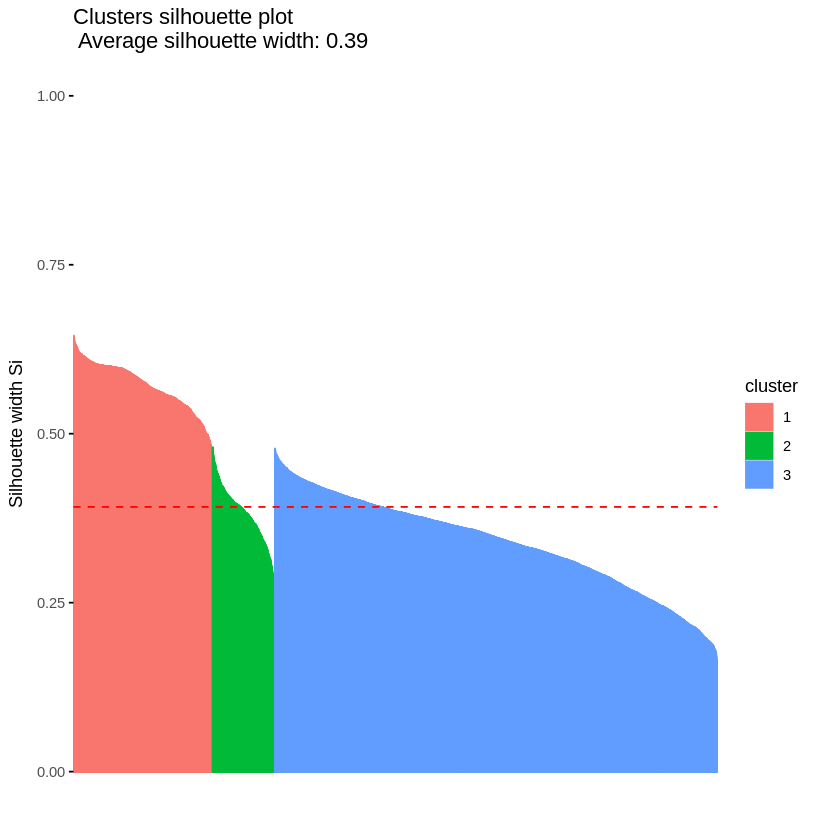

In [120]:
fviz_silhouette(sil)